# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

###### Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Import tqdm for progress bar
from tqdm import tqdm

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [3]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt) 

In [4]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


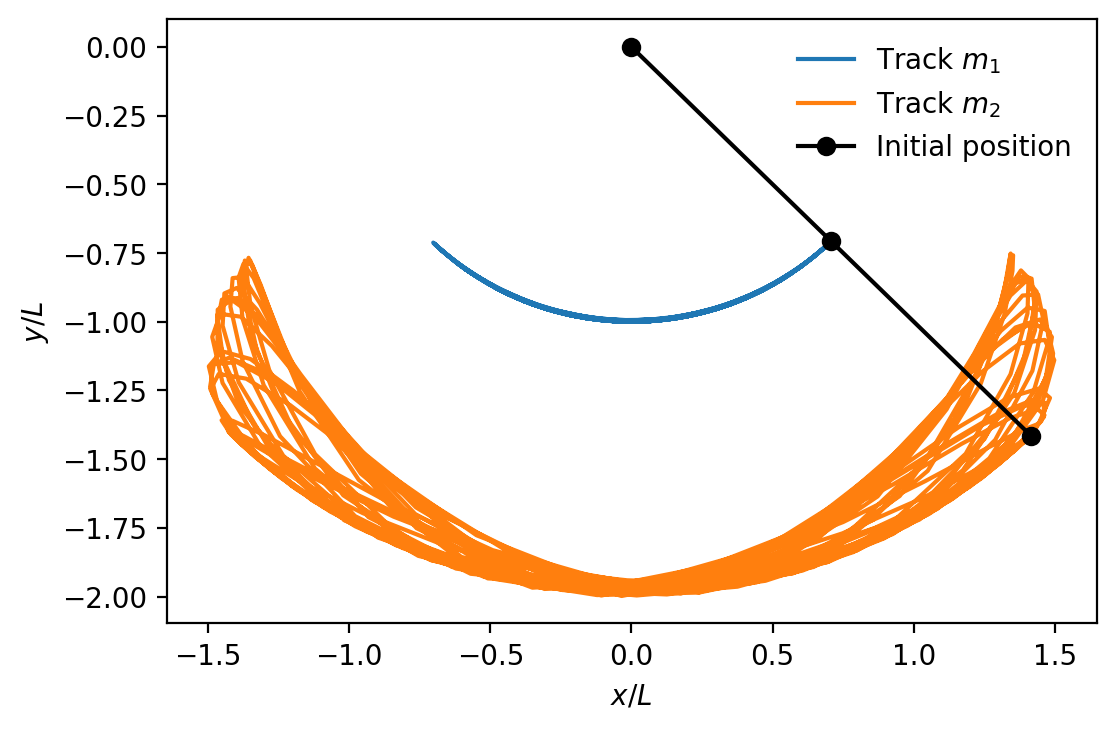

In [5]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

### Part 1:  Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 

In [6]:
#the following code is adapted from [1]
#DEFINE RECURENCE NUERAL NETWORK (RNN):


model=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model.add(keras.layers.LSTM(50,input_shape=(None, 4))) 

#from sequential to flat NN:
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer

#output layer with 4 nueron for each x1, x2, y1 or y2:
model.add(keras.layers.Dense(4, activation='linear')) 

model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11000     
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               26112     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 103,292
Trainable params: 103,292
Non-trainable params: 0
_________________________________________________________________


We need the main (the ones that the graph plots) outputs  of the rhs equation (y-axis and x-axis), which are 1D arrays, into a series of overlapping windows which our RNN can read and run. We do this with our `create_dataset` function defined below. It returns a tuple of the array of x1,x2,y1 and y2 values. There are 2 arrays as outputs; for input (input into NN) and label (target data) data. So it is a 3D matrix with 4 columns for the tuples of the array of x1,x2,y1 and y2; each column is either x1,x2,y1 or y2 (details below). First, we will obtiain test and training data for y1, y2 and x1, x2 then use `create_dataset` to convert the training and test data 1D arrays into a 3D array of tuple of input and target arrays. [2]

In [9]:
windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#the following function was adapted from [2] 
def create_dataset(dataset,offset, windowsize):
    '''INPUTS:
    dataset: the 4-row array of x1,y1,x2 and y2 for either training or test
    offset: how many samples into the future to predict
    OUTPUTS:
    input_data: tuple of dataset for input into RNN
    label_data: tuple of dataset for target of RNN
    '''
    
    input_data, label_data = [], [] 
    #looping over the dataset
    for i in range(windowsize, len(dataset[0]) - offset):
        a = dataset[:,(i-windowsize):i] #
        
        input_data.append(a)
        label_data.append(dataset[:,i+offset])  
       
        
    input_data, label_data = np.array(input_data), np.array(label_data)
    return  input_data, label_data


#OBTAINING TEST AND TRAINING DATA:

#we get train the RNN over a limited range of the y data and x data 
#and test it over the full range:

y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)
test_inp, test_lbl = create_dataset(test_data,offset, windowsize)

#NB: label=target

#shapes:
print("The shape of the test data is",test_data.shape, "where the 4 rows are x1_test, y1_test, x2_test and y2_test")
print("The shape of the training data is",test_data.shape, "where the 4 rows are x1_train, y1_train, x2_train, y2_train")
print()
print("The shape of the training input data is",train_inp.shape)
print("The shape of the training label data is",train_lbl.shape)
print()
print("The shape of the test input data is",train_inp.shape)
print("The shape of the test label data is",train_lbl.shape)

The shape of the test data is (4, 501) where the 4 rows are x1_test, y1_test, x2_test and y2_test
The shape of the training data is (4, 501) where the 4 rows are x1_train, y1_train, x2_train, y2_train

The shape of the training input data is (300, 4, 30)
The shape of the training label data is (300, 4)

The shape of the test input data is (300, 4, 30)
The shape of the test label data is (300, 4)


We wil now use the training input and label data to train our RNN using a for loop for each step:

In [8]:
#the followin code is adapted from [1]:

steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step


for i in tqdm(range(steps)):
    
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    

    costs[i]=model.train_on_batch(in_train ,targ_train) #Train the network and append to 'costs' empty array


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.80it/s]


Plot costs vs steps for the training data:

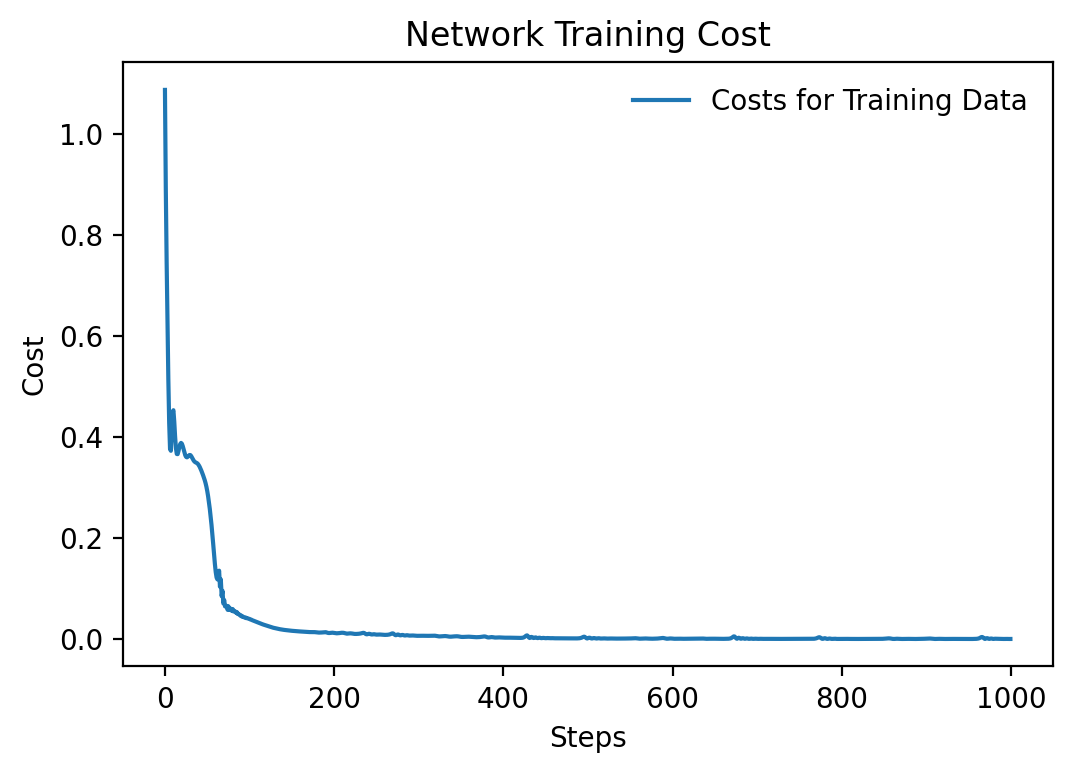

In [9]:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

In [10]:
print("The final cost for training data is",costs[-1])

The final cost for training data is 0.0004032364522572607


Use `predict_on_batch` to test the RNN with the test data:

In [11]:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=model.predict_on_batch(in_test) #gives output from RNN
print(test.shape)
print(test_lbl.shape)

(451, 4)
(451, 4)


Plot the RNN for y1 and y2 in the future (t0+ 20*dt):

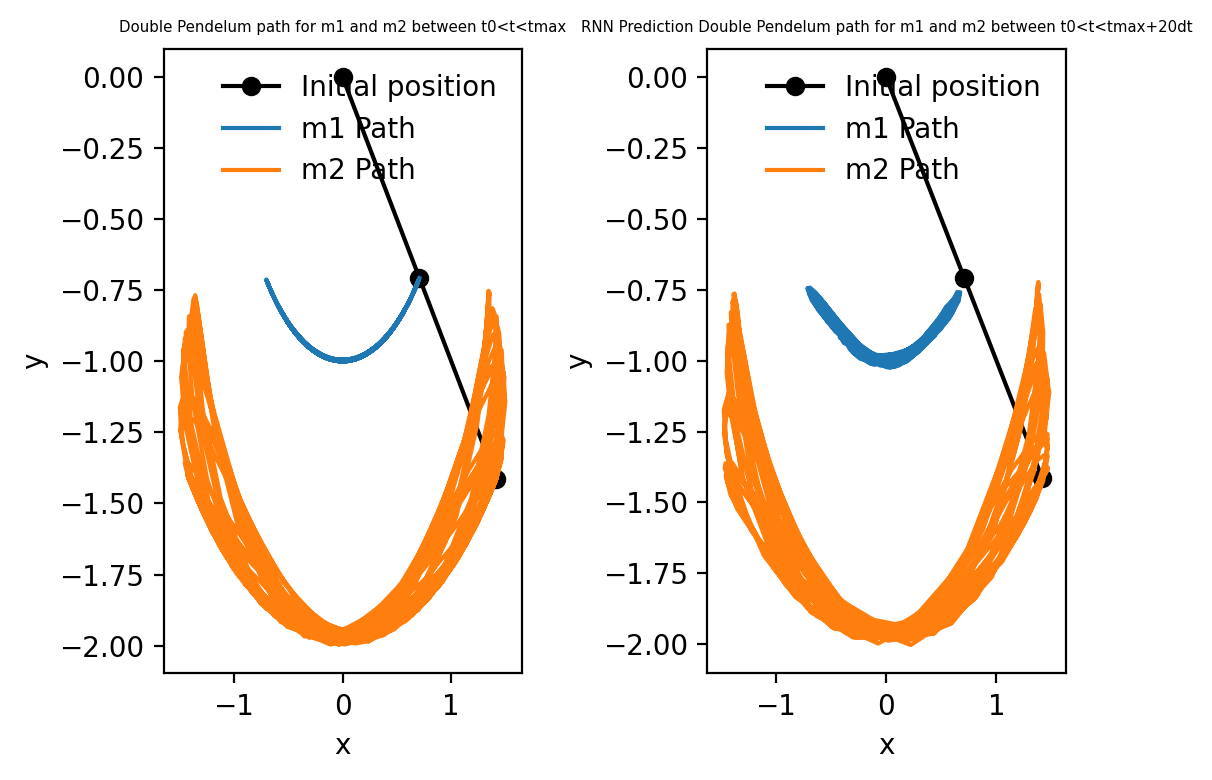

In [12]:
fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

### Part 1 Comments:
For m2, the RNN does an almost perfect job at predicting. However, for m1 it is less accurate which could be due deficiencies in the nature of numerical methods.\
NB: I could have used `model.fit` to train the RNN and `model.evaluate` to test the RNN.

### Part 2: How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

New Initial Condition: $z_0=[\pi/2,1,\pi/2,1]$. 

In [13]:
z0=[np.pi/6,0,np.pi/6,0]

Obtain all the results from rhs again. And obtain new test data:

In [14]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)
test_inp, test_lbl = create_dataset(test_data,offset, windowsize)

(4, 501)


Plot and test:

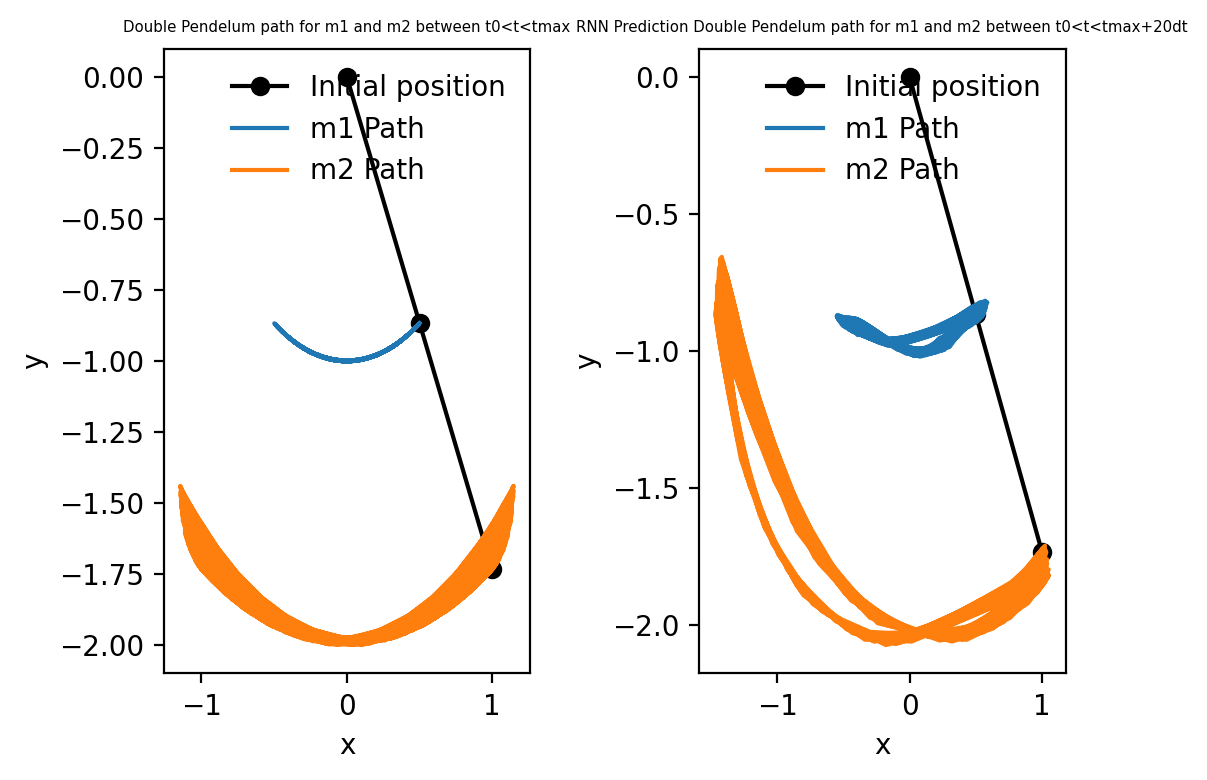

In [15]:
#Test w new test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=model.predict_on_batch(in_test) #gives output from RNN    



fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

𝑥  and 𝑦 vs time:

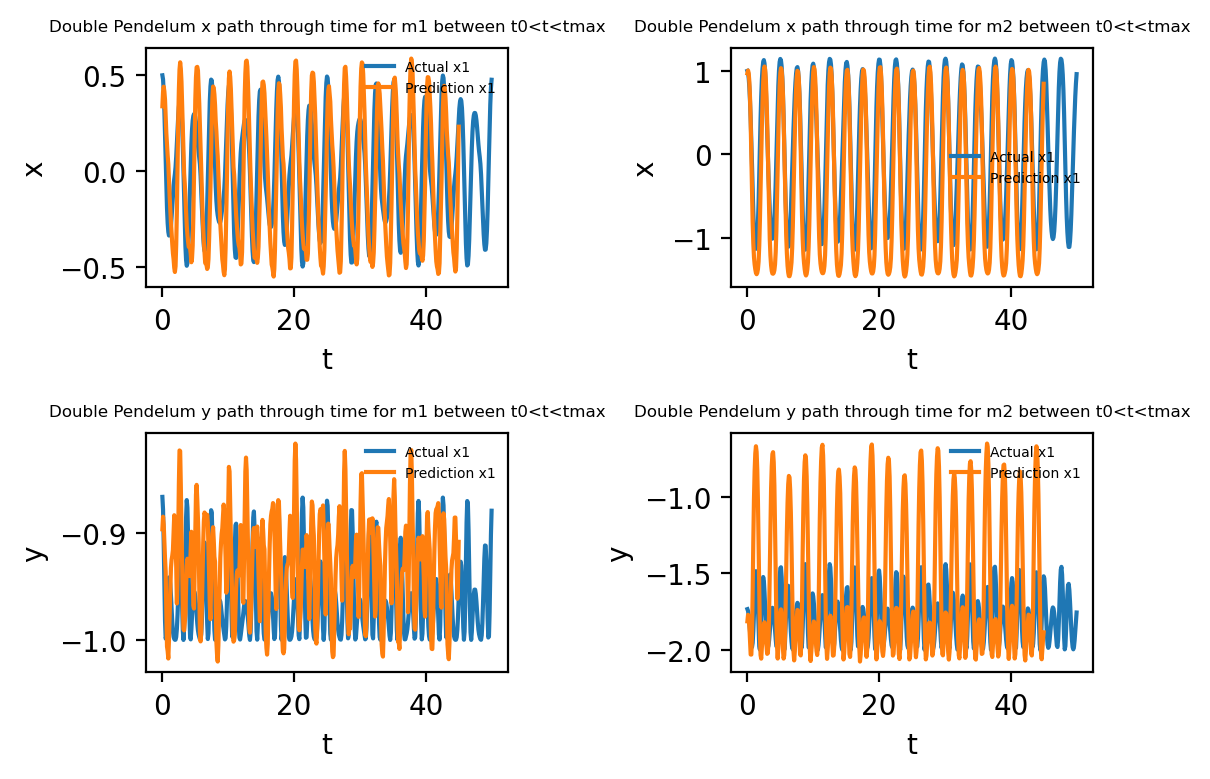

In [16]:
fig,ax=plt.subplots(nrows=2, ncols=2, )

#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test[:,0])],test[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})

#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test[:,2])],test[:,2],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})

#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test[:,1])],test[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})

#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test[:,3])],test[:,3],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})



fig.tight_layout()

New Initial Condition: $z_0=[\pi/8,\pi/4,\pi/8,\pi/4]$. 

In [17]:
z0=[np.pi/8,np.pi/4,np.pi/8,np.pi/4]

Obtain all the results from rhs again. And obtain new test data:

In [18]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)
test_inp, test_lbl = create_dataset(test_data,offset, windowsize)

(4, 501)


Plot and Test:

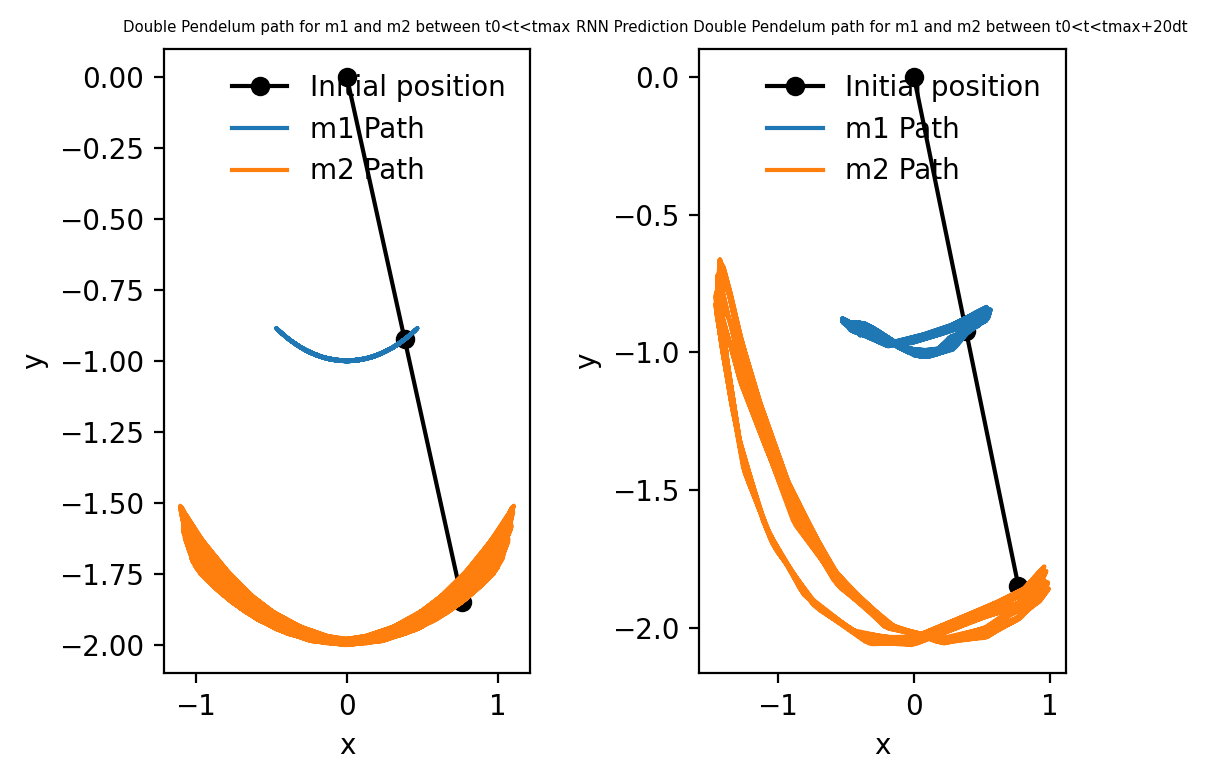

In [19]:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=model.predict_on_batch(in_test) #gives output from RNN    


fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

𝑥  and 𝑦 vs time

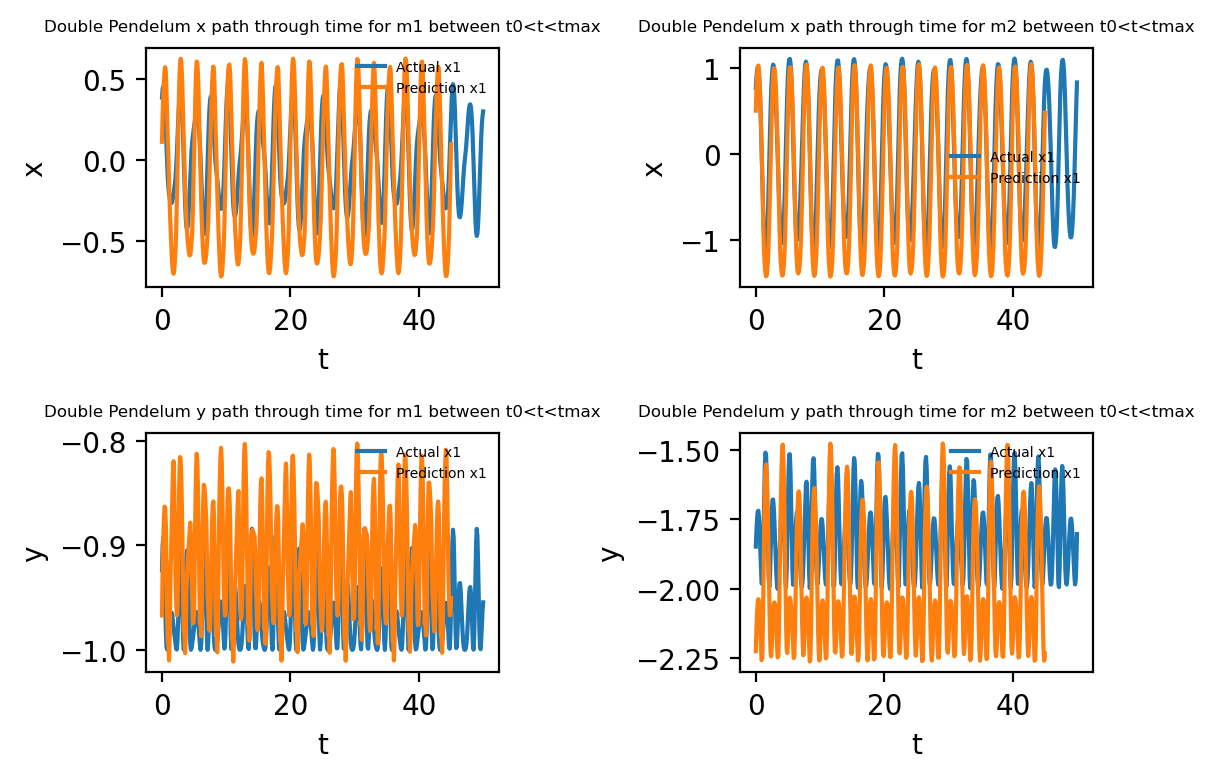

In [55]:
fig,ax=plt.subplots(nrows=2, ncols=2, )

#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test[:,0])],test[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})

#m2_x:
ax[0,1].plot(t,x2,label="Actual x2")
ax[0,1].plot(t[:len(test[:,2])],test[:,2],label="Prediction x2")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})

#m1_y:
ax[1,0].plot(t,y1,label="Actual y1")
ax[1,0].plot(t[:len(test[:,1])],test[:,1],label="Prediction y1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})

#m2_y:
ax[1,1].plot(t,y2,label="Actual y2")
ax[1,1].plot(t[:len(test[:,3])],test[:,3],label="Prediction y2")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})



fig.tight_layout()

### Part 2 Comments:

The RNN does not predict either changes in iniital conditions well. This is also evident by the x and y against t graphs.

### 3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

Set z0 back to original and obtain neccesary values again:

In [20]:
z0=[np.pi/4,0,np.pi/4,0]

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

(4, 501)


Create 5 new identical RNNs, each for one of the extrapolation times:

In [21]:
model1=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model1.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model1.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model1.add(keras.layers.Dense(4, activation='linear')) 
model1.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model2=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model2.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model2.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model2.add(keras.layers.Dense(4, activation='linear')) 
model2.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model3=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model3.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model3.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model3.add(keras.layers.Dense(4, activation='linear')) 
model3.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model4.add(keras.layers.Dense(4, activation='linear')) 
model4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model5.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model5.add(keras.layers.Dense(4, activation='linear')) 
model5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

Obtain inputs and targets for test and training data... for each extrapolation time using a for loop:

In [22]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tstARRAY =[]
trgt_tstARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,20):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp, test_lbl = create_dataset(test_data,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1])
    targ_test = test_lbl.reshape(test_lbl.shape[0], test_lbl.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tstARRAY.append(in_test)
    trgt_tstARRAY.append(targ_test)
    


Train and test for each extrapolation time using `.fit` and obtain accuracy using `.evaluate`:

12/12 [==============================] - 0s 5ms/step - loss: 0.0159 - accuracy: 0.9704


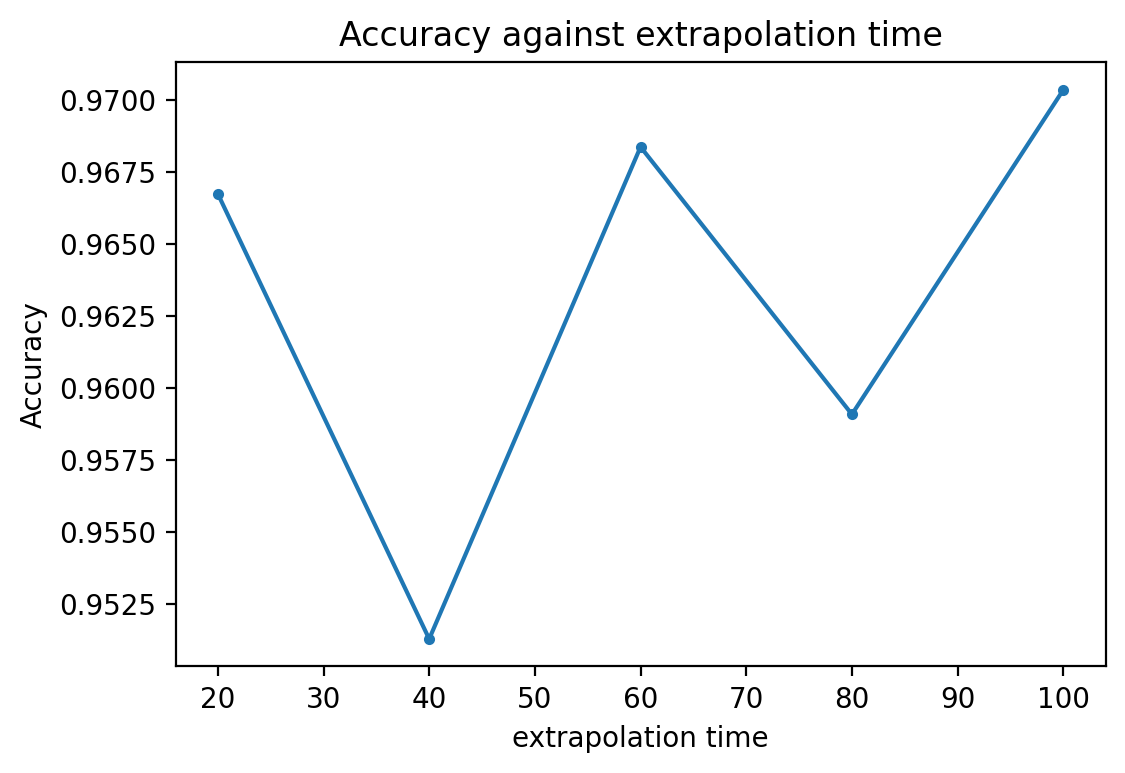

In [23]:
history1 = model1.fit(inp_trnARRAY[0], trgt_trnARRAY[0], epochs=30, validation_data= (inp_tstARRAY[0],trgt_tstARRAY[0] ), verbose=0)
test_loss1, test_acc1 = model1.evaluate(inp_tstARRAY[0], trgt_tstARRAY[0] , verbose=1)

history2 = model2.fit(inp_trnARRAY[1], trgt_trnARRAY[1], epochs=30, validation_data= (inp_tstARRAY[1],trgt_tstARRAY[1] ), verbose=0)
test_loss2, test_acc2 = model2.evaluate(inp_tstARRAY[1], trgt_tstARRAY[1] , verbose=1)

history3 = model3.fit(inp_trnARRAY[2], trgt_trnARRAY[2], epochs=30, validation_data= (inp_tstARRAY[2],trgt_tstARRAY[2] ), verbose=0)
test_loss3, test_acc3 = model3.evaluate(inp_tstARRAY[2], trgt_tstARRAY[2] , verbose=1)

history4 = model4.fit(inp_trnARRAY[3], trgt_trnARRAY[3], epochs=30, validation_data= (inp_tstARRAY[3],trgt_tstARRAY[3] ), verbose=0)
test_loss4, test_acc4 = model4.evaluate(inp_tstARRAY[3], trgt_tstARRAY[3] , verbose=1)

history5 = model5.fit(inp_trnARRAY[4], trgt_trnARRAY[4], epochs=30, validation_data= (inp_tstARRAY[4],trgt_tstARRAY[4] ), verbose=0)
test_loss5, test_acc5 = model5.evaluate(inp_tstARRAY[4], trgt_tstARRAY[4] , verbose=1)


test_accARRAY= np.array([test_acc1, test_acc2, test_acc3, test_acc4, test_acc5])

plt.figure()
plt.plot(np.arange(20,101,20), test_accARRAY, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Accuracy")
plt.title("Accuracy against extrapolation time")
plt.show()

### Part 3 Comments:
As the extrapolation time increases, the general LOMBF also increases (ie there is an incline in the line line going through the middle of the data points). Also, the accuracies are all over 95%. Therefore, the RNN is accurate for further in the future up to, at least, t0 + 100dt.

### Part 4: Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.

Change initial condition:

In [6]:
#Starting angles
z0=[np.pi/2,0,np.pi/2,0]

Obtain new essential variables:

(4, 501)


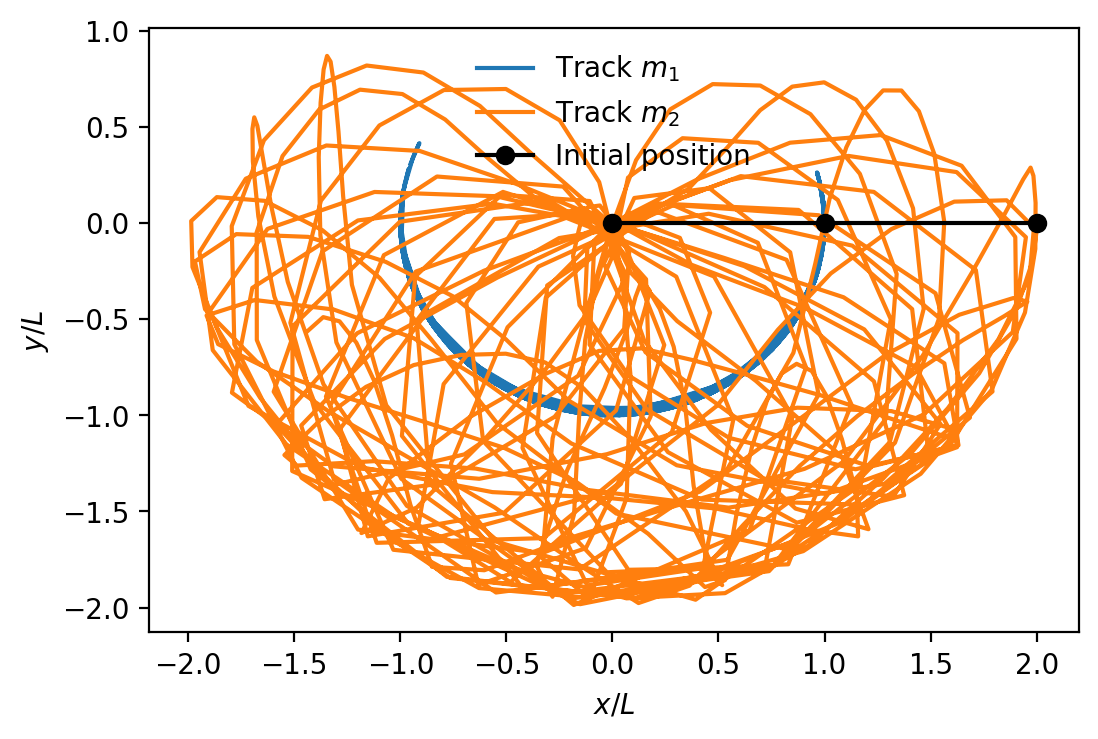

In [7]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration
#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt) 



# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)




fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

Repeat steps 1-3 all together:

#### PART 1:

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               26112     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 103,292
Trainable params: 103,292
Non-trainable params: 0
_________________________________________________________________


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.37it/s]


The final cost for training data is 0.0011898300144821405
(451, 4)
(451, 4)


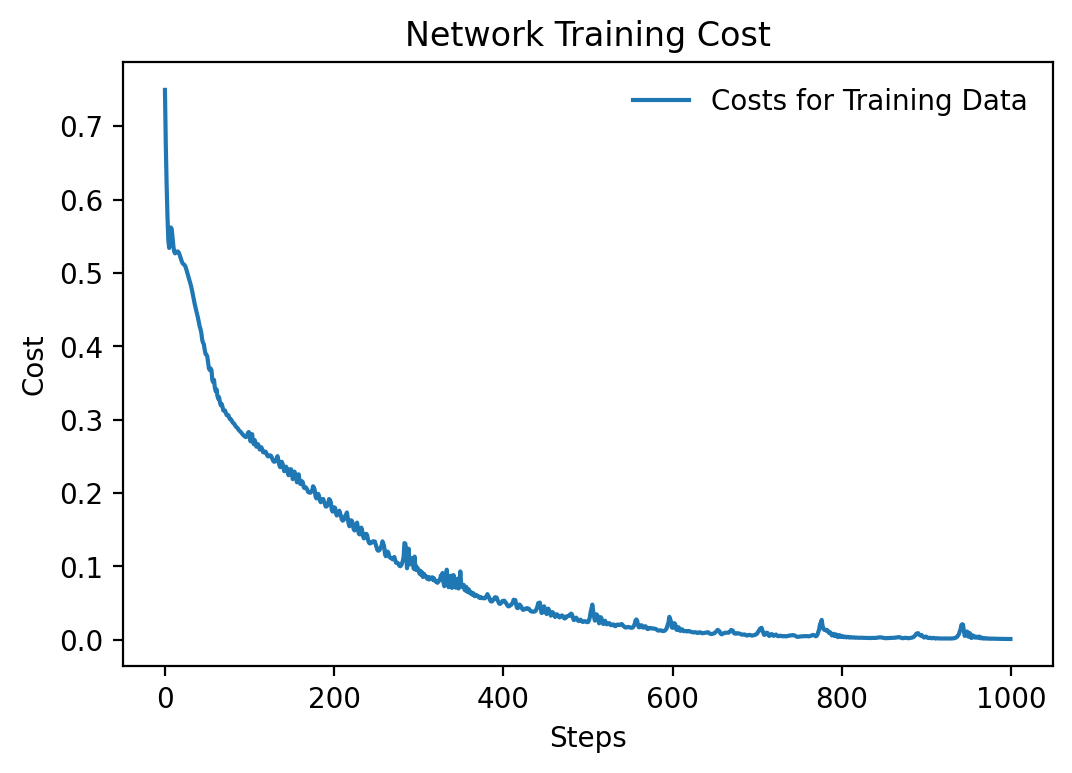

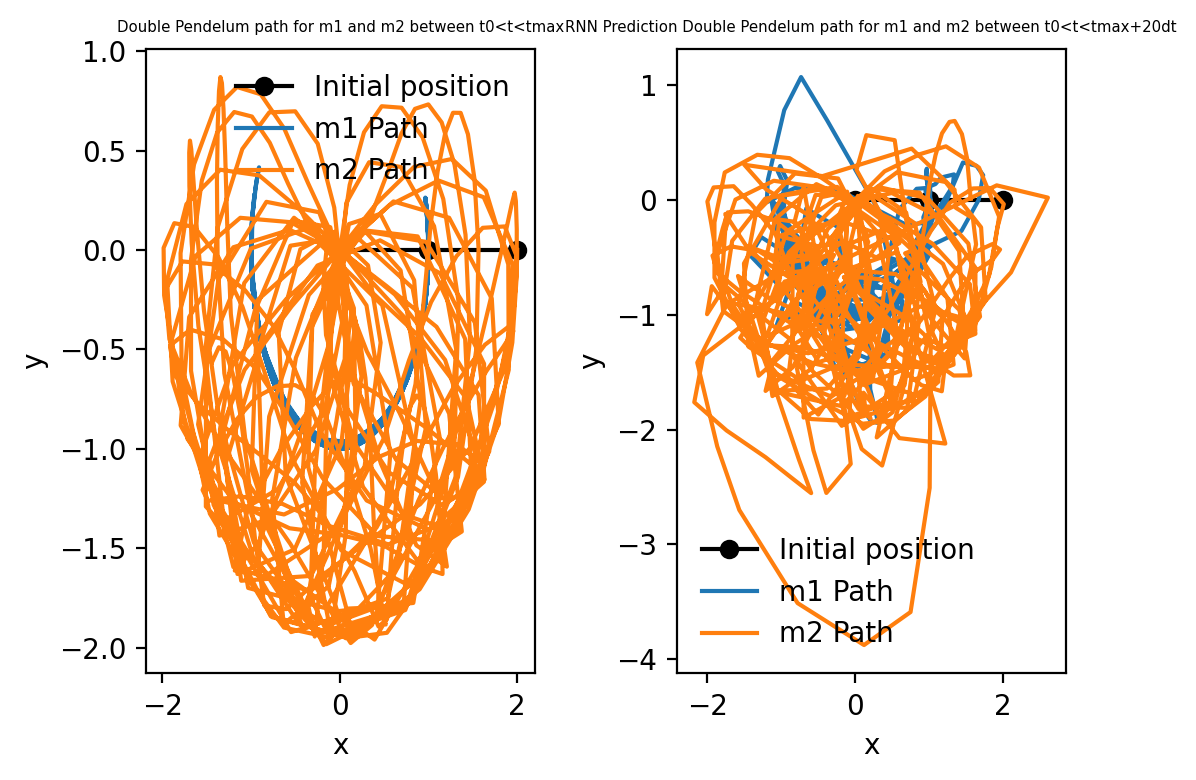

In [10]:
#DEFINE RECURENCE NUERAL NETWORK (RNN):


modelP4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
modelP4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
modelP4.add(keras.layers.Flatten())
modelP4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
modelP4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
modelP4.add(keras.layers.Dense(4, activation='linear')) 
modelP4.compile(loss='mean_squared_error',optimizer='adam')
modelP4.summary()


windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition

#OBTAINING TEST AND TRAINING DATA:
#we get train the RNN over a limited range of the y data and x data 
#and test it over the full range:
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data
y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range
x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data
x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 

#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T

#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)
test_inp, test_lbl = create_dataset(test_data,offset, windowsize)

#train:
steps=1000  #Number of training steps
costs=np.zeros(steps) #empty array for cost along each step
for i in tqdm(range(steps)):
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    costs[i]=modelP4.train_on_batch(in_train ,targ_train) #Train the network and append to 'costs' empty array



#plot train cost:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

print("The final cost for training data is",costs[-1])


#test:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=modelP4.predict_on_batch(in_test) #gives output from RNN
print(test.shape)
print(test_lbl.shape)



fig,ax=plt.subplots(nrows=1, ncols=2, )
#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()
fig.tight_layout()

#### PART 2:

(4, 501)
(4, 501)


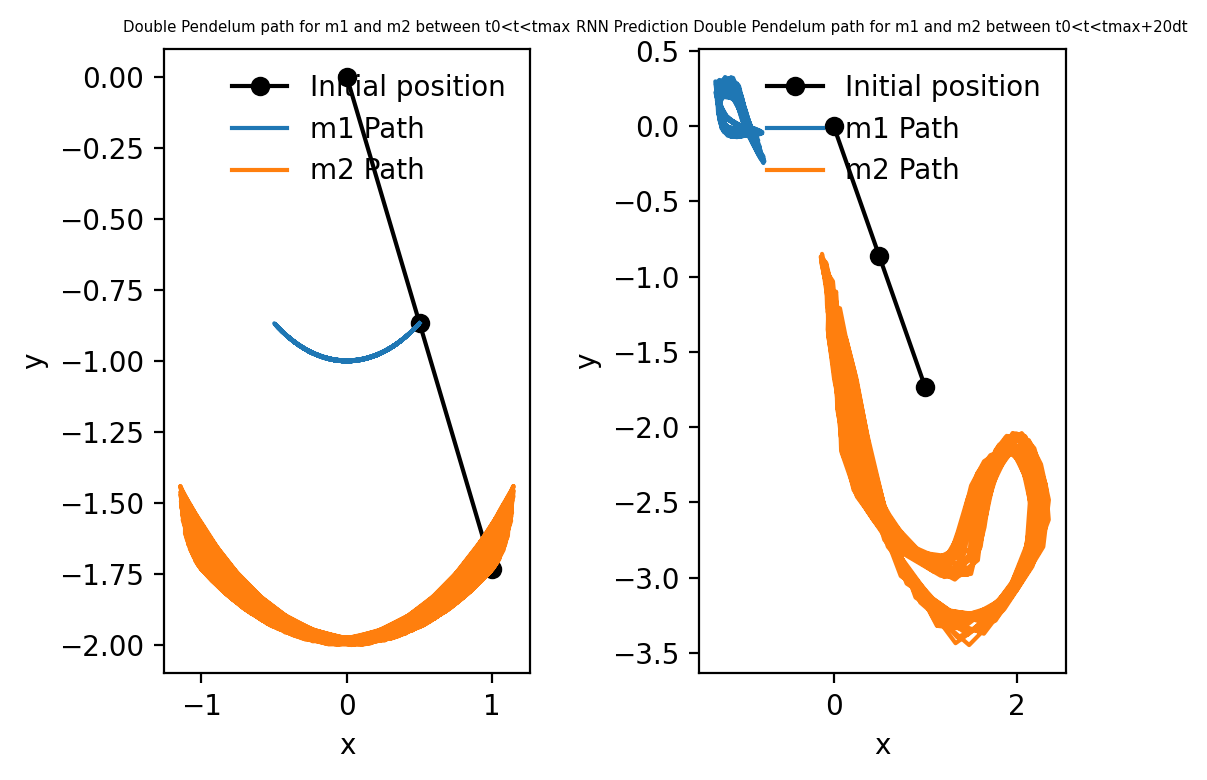

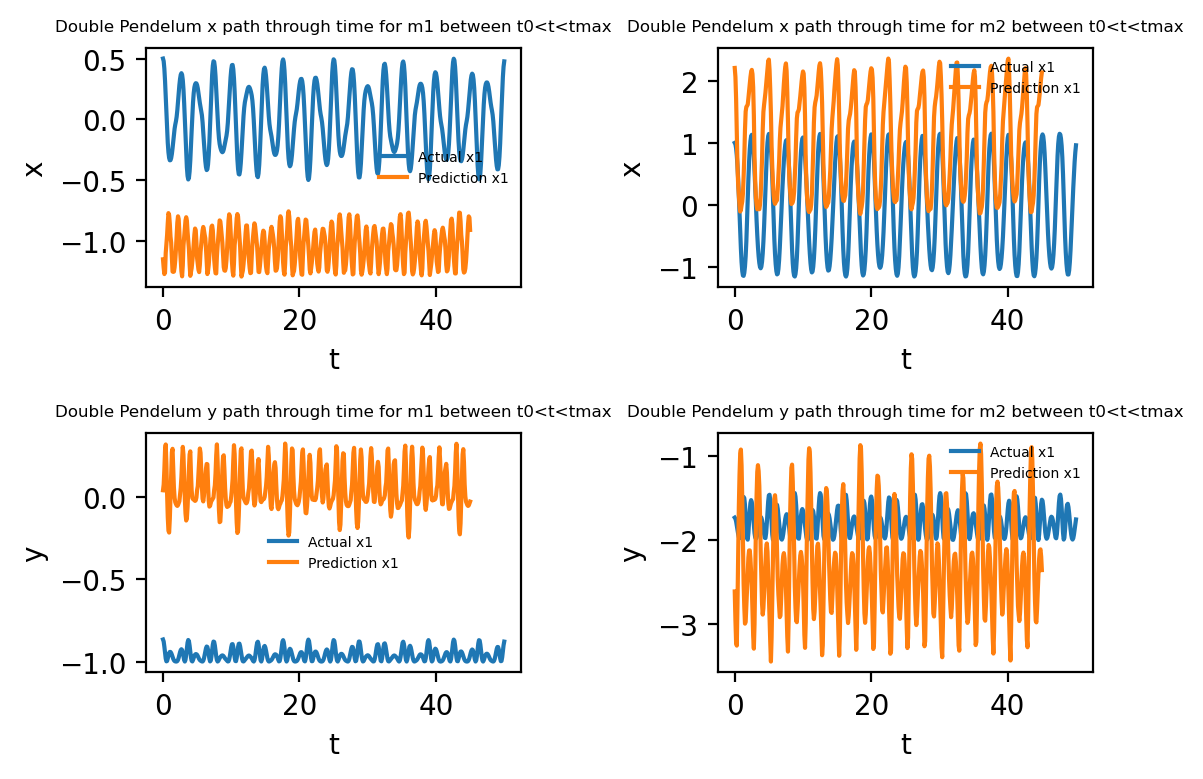

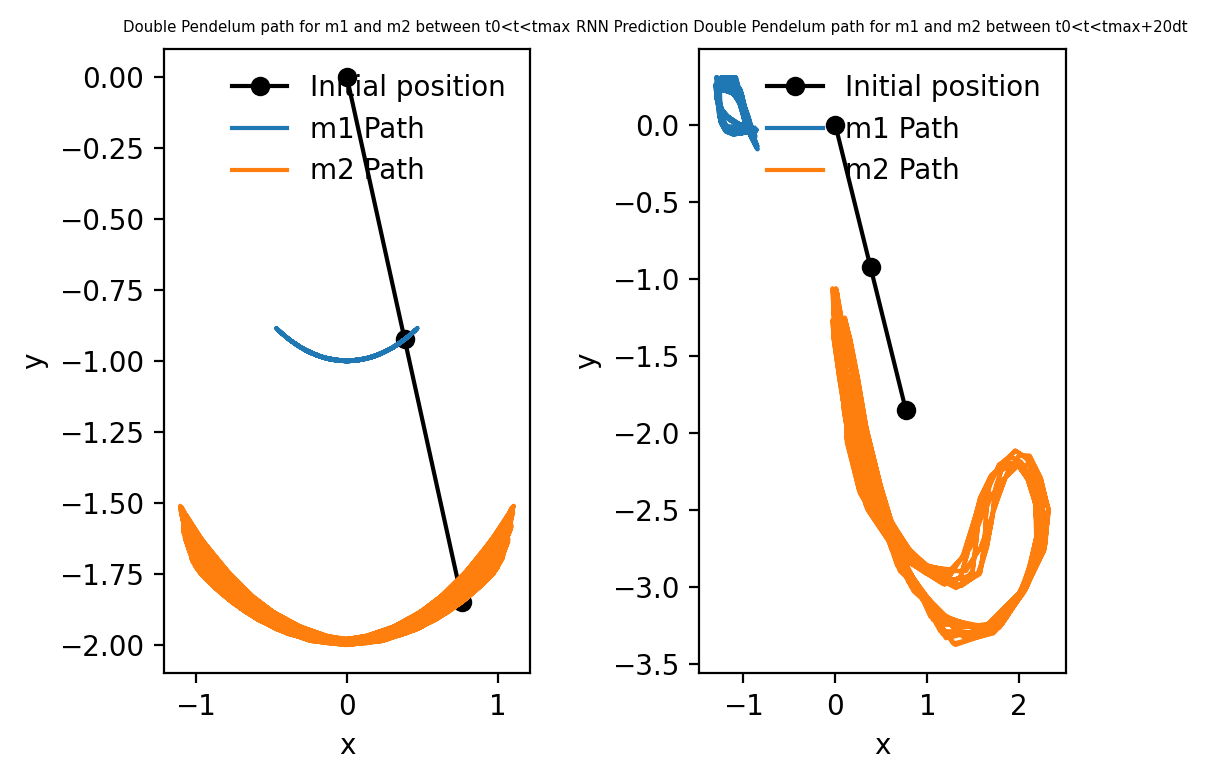

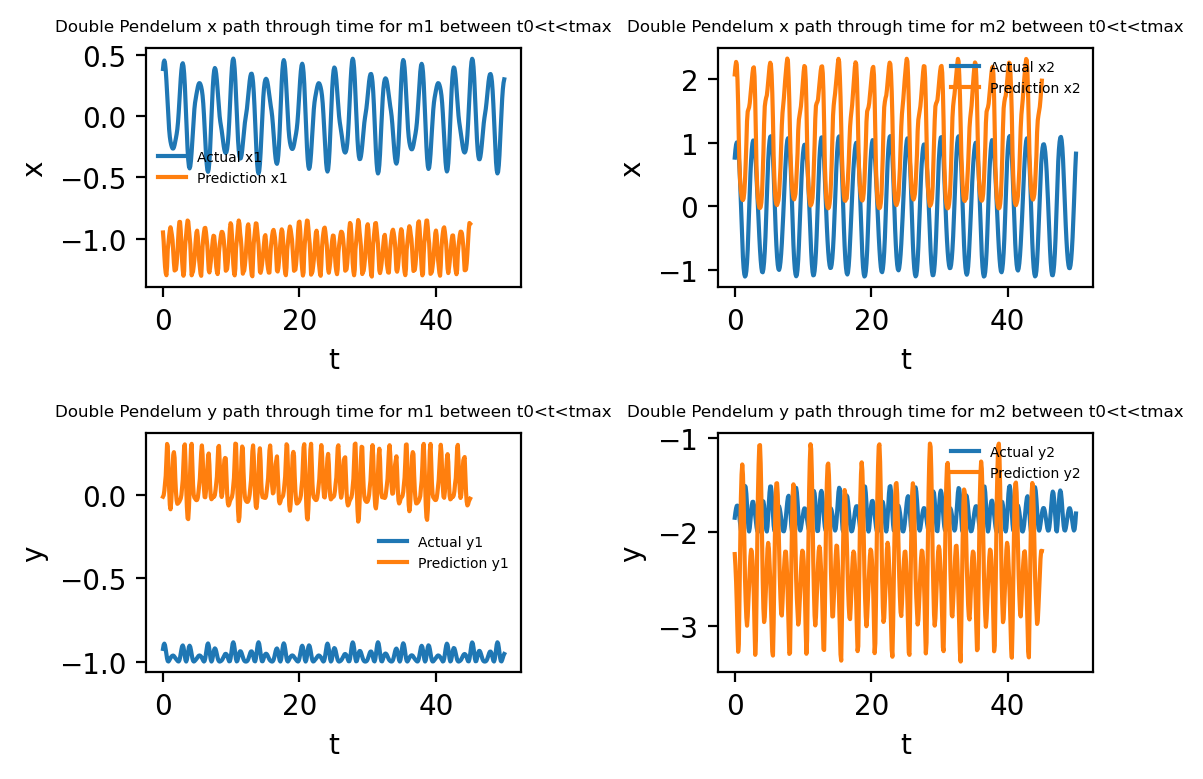

In [11]:
### Part 2: How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
z0=[np.pi/6,0,np.pi/6,0]


# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data
y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range
x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data
x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)
test_inp, test_lbl = create_dataset(test_data,offset, windowsize)



#Test w new test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=modelP4.predict_on_batch(in_test) #gives output from RNN    



fig,ax=plt.subplots(nrows=1, ncols=2, )
#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()
fig.tight_layout()


fig,ax=plt.subplots(nrows=2, ncols=2, )
#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test[:,0])],test[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})
#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test[:,2])],test[:,2],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})
#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test[:,1])],test[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})
#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test[:,3])],test[:,3],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})
fig.tight_layout()



######################################



z0=[np.pi/8,np.pi/4,np.pi/8,np.pi/4]
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data
y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range
x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data
x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 

#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset)
test_inp, test_lbl = create_dataset(test_data,offset)


#we first have to reshape the test input data for the same reasons we did for the training input data
in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test=modelP4.predict_on_batch(in_test) #gives output from RNN    

fig,ax=plt.subplots(nrows=1, ncols=2, )
#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test[:,0], test[:,1],label="m1 Path")
ax[1].plot(test[:,2], test[:,3],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()
fig.tight_layout()


fig,ax=plt.subplots(nrows=2, ncols=2, )
#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test[:,0])],test[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})
#m2_x:
ax[0,1].plot(t,x2,label="Actual x2")
ax[0,1].plot(t[:len(test[:,2])],test[:,2],label="Prediction x2")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})
#m1_y:
ax[1,0].plot(t,y1,label="Actual y1")
ax[1,0].plot(t[:len(test[:,1])],test[:,1],label="Prediction y1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})
#m2_y:
ax[1,1].plot(t,y2,label="Actual y2")
ax[1,1].plot(t[:len(test[:,3])],test[:,3],label="Prediction y2")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})
fig.tight_layout()

#### PART 3:

In [12]:
### 3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
z0=[np.pi/2,0,np.pi/2,0]

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 # Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data
y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range
x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data
x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#stack each x1,y1,x2 or y2 test data on top of each other in an array:
test_data = np.column_stack((x1_test, y1_test, x2_test, y2_test)).T
#stack each x1,y1,x2 or y2 training data on top of each other in an array:
train_data = np.column_stack((x1_train, y1_train, x2_train, y2_train)).T



model1P4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model1P4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model1P4.add(keras.layers.Flatten())
model1P4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model1P4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model1P4.add(keras.layers.Dense(4, activation='linear')) 
model1P4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model2P4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model2P4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model2P4.add(keras.layers.Flatten())
model2P4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model2P4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model2P4.add(keras.layers.Dense(4, activation='linear')) 
model2P4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model3P4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model3P4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model3P4.add(keras.layers.Flatten())
model3P4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model3P4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model3P4.add(keras.layers.Dense(4, activation='linear')) 
model3P4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model4P4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model4P4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model4P4.add(keras.layers.Flatten())
model4P4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model4P4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model4P4.add(keras.layers.Dense(4, activation='linear')) 
model4P4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model5P4=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model5P4.add(keras.layers.LSTM(50,input_shape=(None, 4))) 
#from sequential to flat NN:
model5P4.add(keras.layers.Flatten())
model5P4.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model5P4.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model5P4.add(keras.layers.Dense(4, activation='linear')) 
model5P4.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

(4, 501)


12/12 [==============================] - 0s 6ms/step - loss: 0.3901 - accuracy: 0.4825


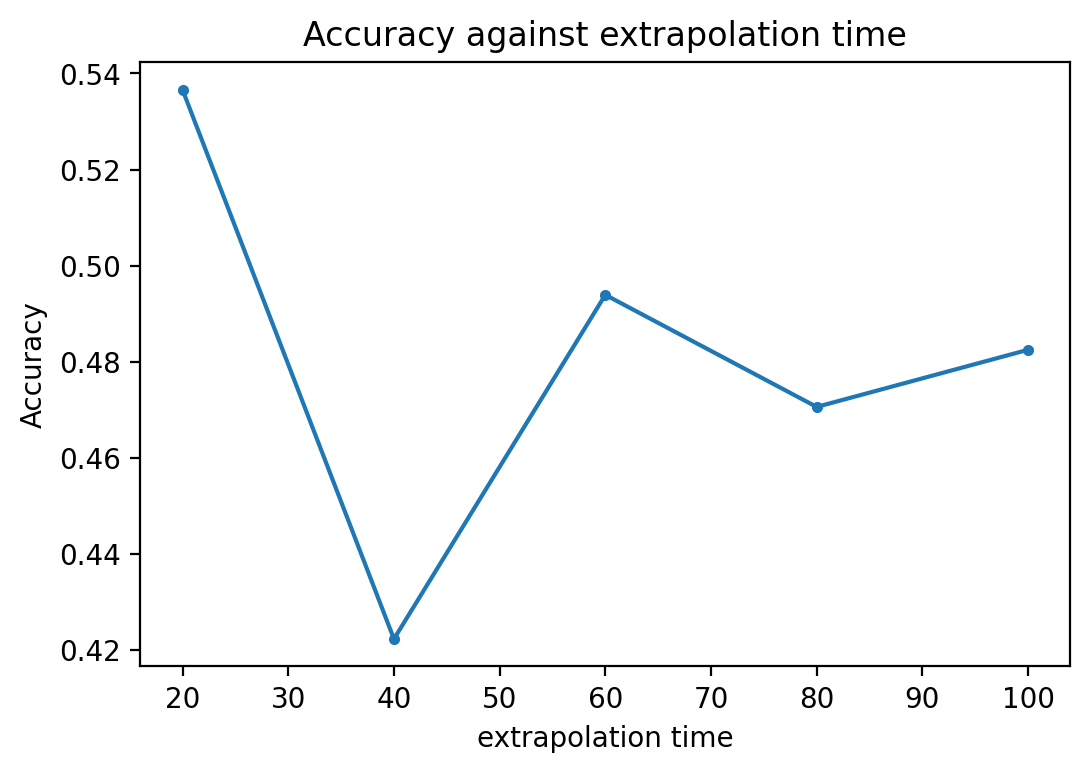

In [13]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tstARRAY =[]
trgt_tstARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,20):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    test_inp, test_lbl = create_dataset(test_data,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    in_test = test_inp.reshape(test_inp.shape[0],windowsize, test_inp.shape[1])
    targ_test = test_lbl.reshape(test_lbl.shape[0], test_lbl.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    inp_tstARRAY.append(in_test)
    trgt_tstARRAY.append(targ_test)
    




history1 = model1P4.fit(inp_trnARRAY[0], trgt_trnARRAY[0], epochs=30, validation_data= (inp_tstARRAY[0],trgt_tstARRAY[0] ), verbose=0)
test_loss1, test_acc1 = model1P4.evaluate(inp_tstARRAY[0], trgt_tstARRAY[0] , verbose=1)
history2 = model2P4.fit(inp_trnARRAY[1], trgt_trnARRAY[1], epochs=30, validation_data= (inp_tstARRAY[1],trgt_tstARRAY[1] ), verbose=0)
test_loss2, test_acc2 = model2P4.evaluate(inp_tstARRAY[1], trgt_tstARRAY[1] , verbose=1)
history3 = model3P4.fit(inp_trnARRAY[2], trgt_trnARRAY[2], epochs=30, validation_data= (inp_tstARRAY[2],trgt_tstARRAY[2] ), verbose=0)
test_loss3, test_acc3 = model3P4.evaluate(inp_tstARRAY[2], trgt_tstARRAY[2] , verbose=1)
history4 = model4P4.fit(inp_trnARRAY[3], trgt_trnARRAY[3], epochs=30, validation_data= (inp_tstARRAY[3],trgt_tstARRAY[3] ), verbose=0)
test_loss4, test_acc4 = model4P4.evaluate(inp_tstARRAY[3], trgt_tstARRAY[3] , verbose=1)
history5 = model5P4.fit(inp_trnARRAY[4], trgt_trnARRAY[4], epochs=30, validation_data= (inp_tstARRAY[4],trgt_tstARRAY[4] ), verbose=0)
test_loss5, test_acc5 = model5P4.evaluate(inp_tstARRAY[4], trgt_tstARRAY[4] , verbose=1)


test_accARRAY= np.array([test_acc1, test_acc2, test_acc3, test_acc4, test_acc5])

plt.figure()
plt.plot(np.arange(20,101,20), test_accARRAY, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Accuracy")
plt.title("Accuracy against extrapolation time")
plt.show()

### Part 4 Comments:
The accuracy for all of Part 1-3 has dramatically decreased. This is expectd since the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ give a more complex path.

### Part 5: Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)

First we must redefine each NN used... to have an input of 2 for the training data and data which will have only x2 and y2... ie 2 dimensions (int he case where we run the test data... we must run with x1,y1 and x2,y2 seperatley (but first we ofc must split test data into 2 seperate stacked vectors... one for x1,y1 and other for x2,y2)... but for training ... we only use x2,y2). We must do all of this for each point where we define/redefine the NN and test and training data.

#### Part 1: 

Redefine our RNN as a functoin of the dimensions of input. This way, we can use 2D for training data and 4D for test data:

In [10]:
#DEFINE RECURENCE NUERAL NETWORK (RNN):

#def RNN_P5(dimensions):
modelP5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 'demensions'
modelP5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 

#from sequential to flat NN:
modelP5.add(keras.layers.Flatten())

modelP5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
modelP5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer

#output layer with 4 nueron for each x1, x2, y1 or y2:
modelP5.add(keras.layers.Dense(2, activation='linear')) 

modelP5.compile(loss='mean_squared_error',optimizer='adam')
    
#return modelP5

In [11]:
windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#the following function was adapted from [2] 
def create_dataset(dataset,offset, windowsize):
    '''INPUTS:
    dataset: the 4-row array of x1,y1,x2 and y2 for either training or test
    offset: how many samples into the future to predict
    OUTPUTS:
    input_data: tuple of dataset for input into RNN
    label_data: tuple of dataset for target of RNN
    '''
    
    input_data, label_data = [], [] 
    #looping over the dataset
    for i in range(windowsize, len(dataset[0]) - offset):
        a = dataset[:,(i-windowsize):i] #
        
        input_data.append(a)
        label_data.append(dataset[:,i+offset])  
       
        
    input_data, label_data = np.array(input_data), np.array(label_data)
    return  input_data, label_data


#OBTAINING TEST AND TRAINING DATA:

#we get train the RNN over a limited range of the y data and x data 
#and test it over the full range:

y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)



100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.81it/s]


The final cost for training data is 0.0021461385767906904
(451, 2)
(451, 2)
(451, 2)
(451, 2)


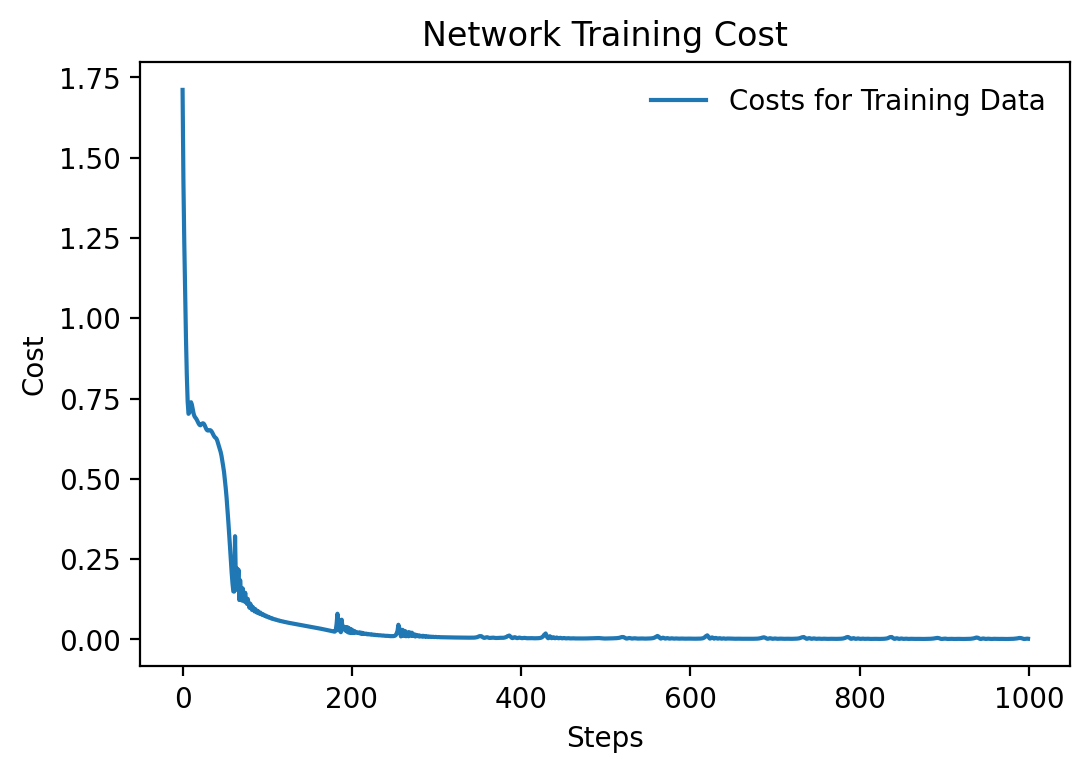

In [12]:
#train:
steps=1000  #Number of training steps

costs=np.zeros(steps) #empty array for cost along each step

for i in tqdm(range(steps)):
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    costs[i]=modelP5.train_on_batch(in_train ,targ_train) #Train the network and append to 'costs' empty array



#plot train cost:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

print("The final cost for training data is",costs[-1])


#test:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1) #gives output from RNN
print(test1.shape)
print(test_lbl1.shape)

Use `predict_on_batch` to test the RNN with the test data:

Plot the RNN for y1 and y2 in the future (t0+ 20*dt):

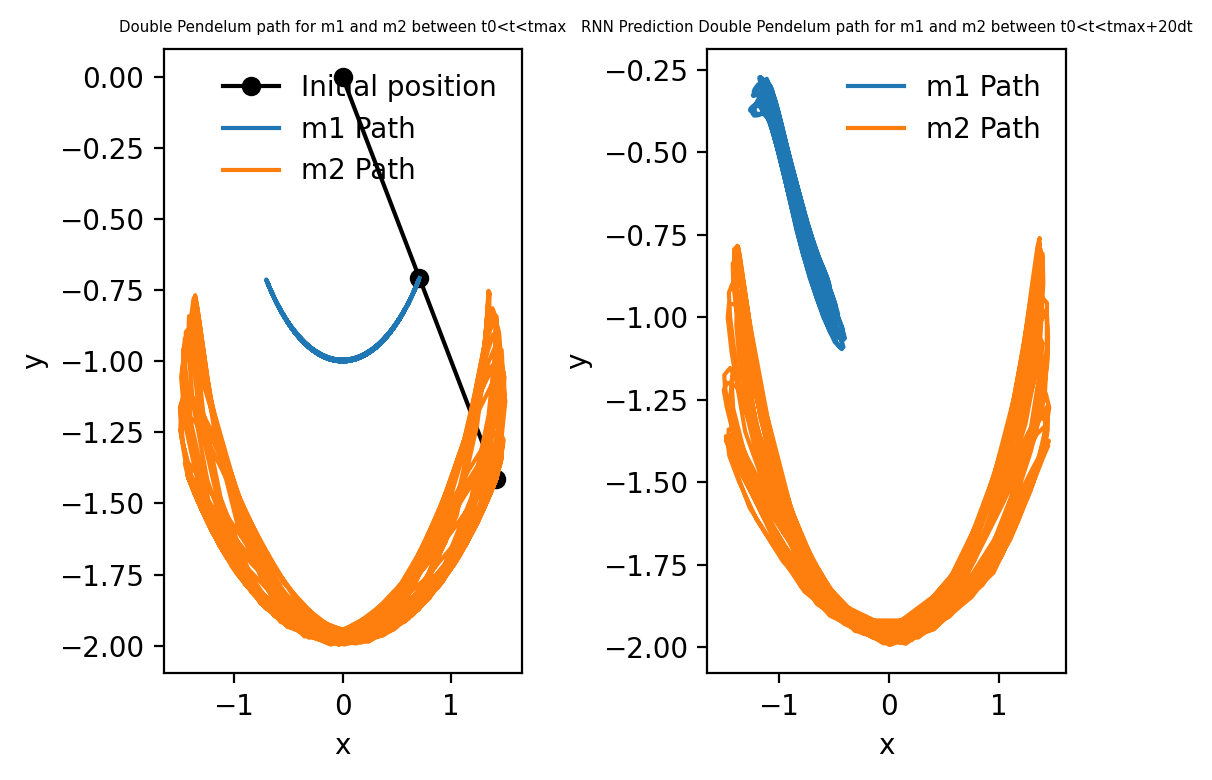

In [13]:
fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
#ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

For m2, the RNN does an almost perfect job at predicting. However, for m1 it is less accurate which could be due deficiencies in the nature of numerical methods.\
NB: I could have used `model.fit` to train the RNN and `model.evaluate` to test the RNN.

#### Part 2: 

New Initial Condition: $z_0=[\pi/2,1,\pi/2,1]$. 

In [14]:
z0=[np.pi/6,0,np.pi/6,0]

Obtain all the results from rhs again. And obtain new test data:

In [16]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)

(4, 501)


Plot and test:

(451, 2)
(451, 2)


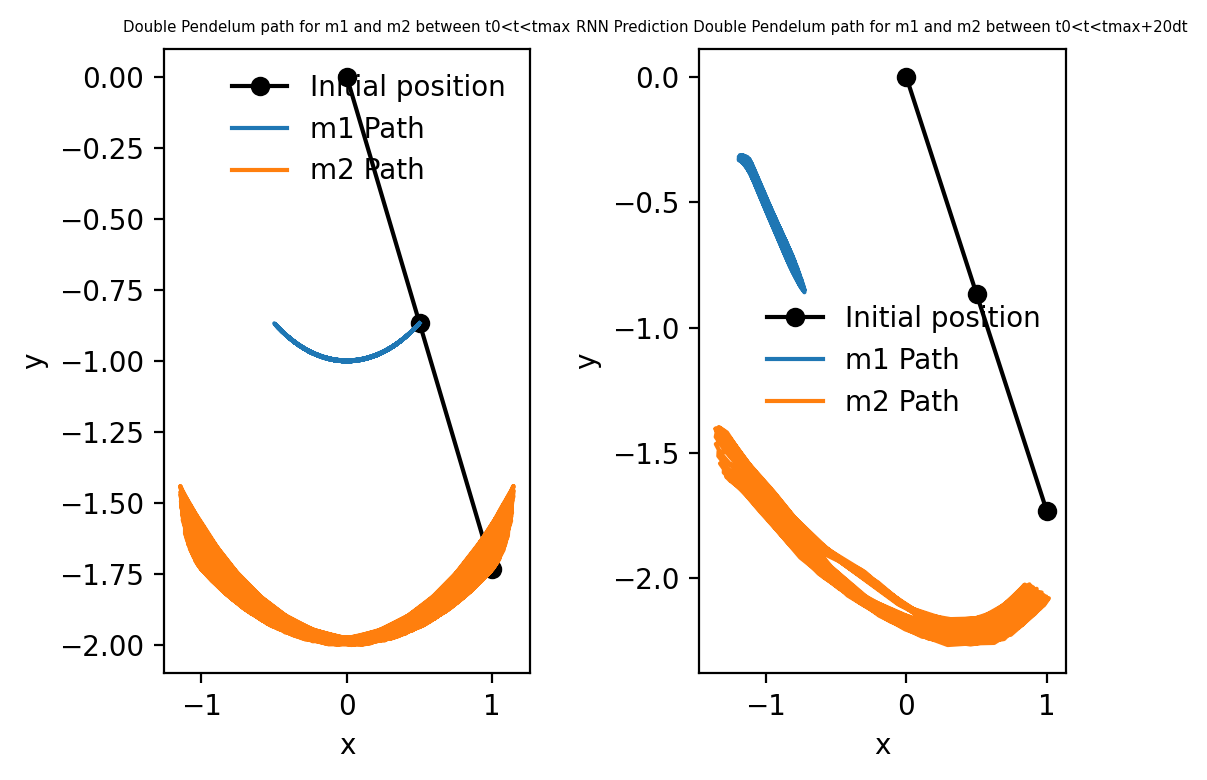

In [17]:
#tEST W NEW test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1)


fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

𝑥  and 𝑦 vs time:

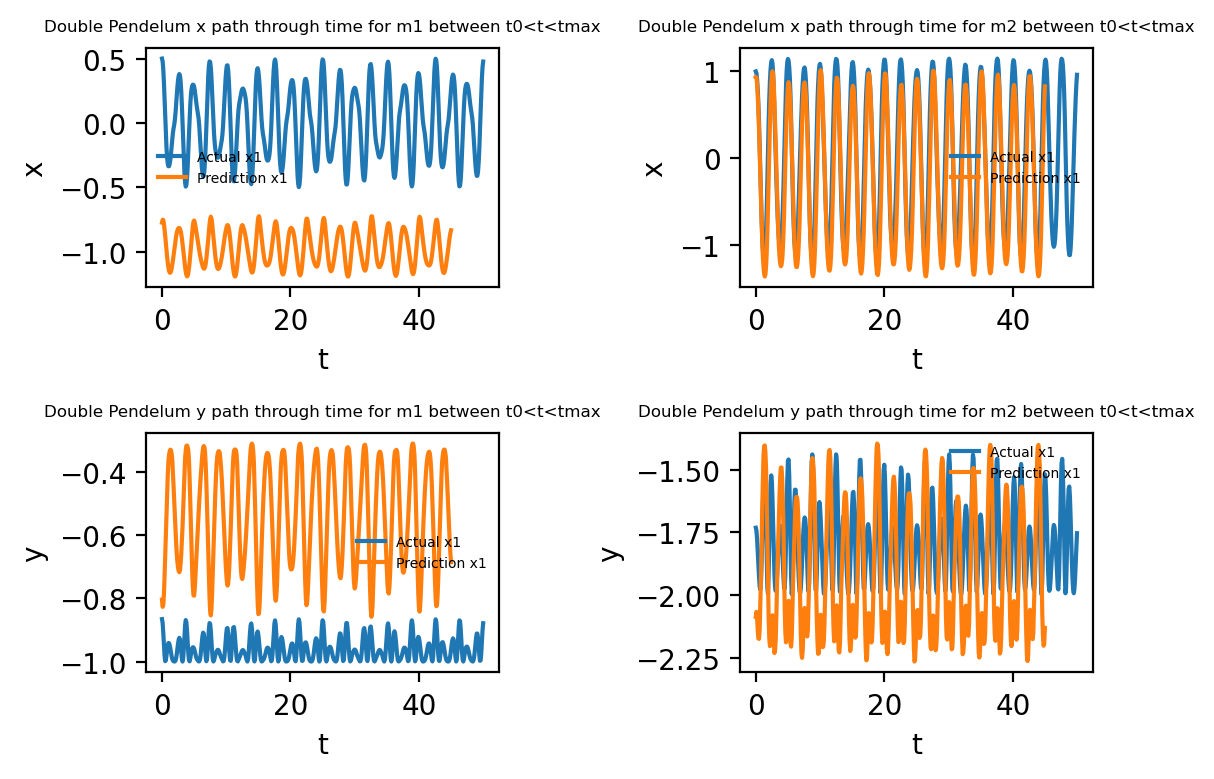

In [19]:
fig,ax=plt.subplots(nrows=2, ncols=2, )

#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test1[:,0])],test1[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})

#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test2[:,0])],test2[:,0],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})

#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test1[:,1])],test1[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})

#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test2[:,1])],test2[:,1],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})



fig.tight_layout()

New Initial Condition: $z_0=[\pi/8,\pi/4,\pi/8,\pi/4]$. 

In [20]:
z0=[np.pi/8,np.pi/4,np.pi/8,np.pi/4]

Obtain all the results from rhs again. And obtain new test data:

In [21]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)

(4, 501)


Plot and Test:

(451, 2)
(451, 2)


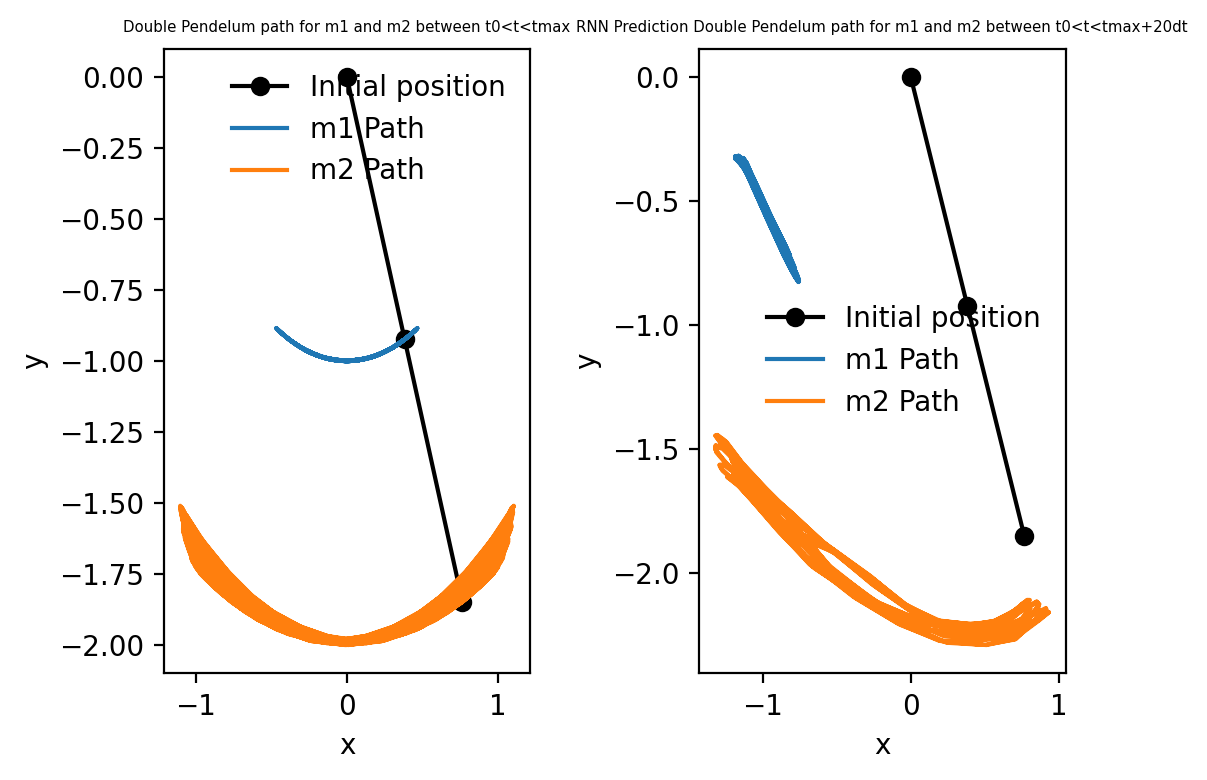

In [22]:
#tEST W NEW test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1)


fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()

#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

𝑥  and 𝑦 vs time

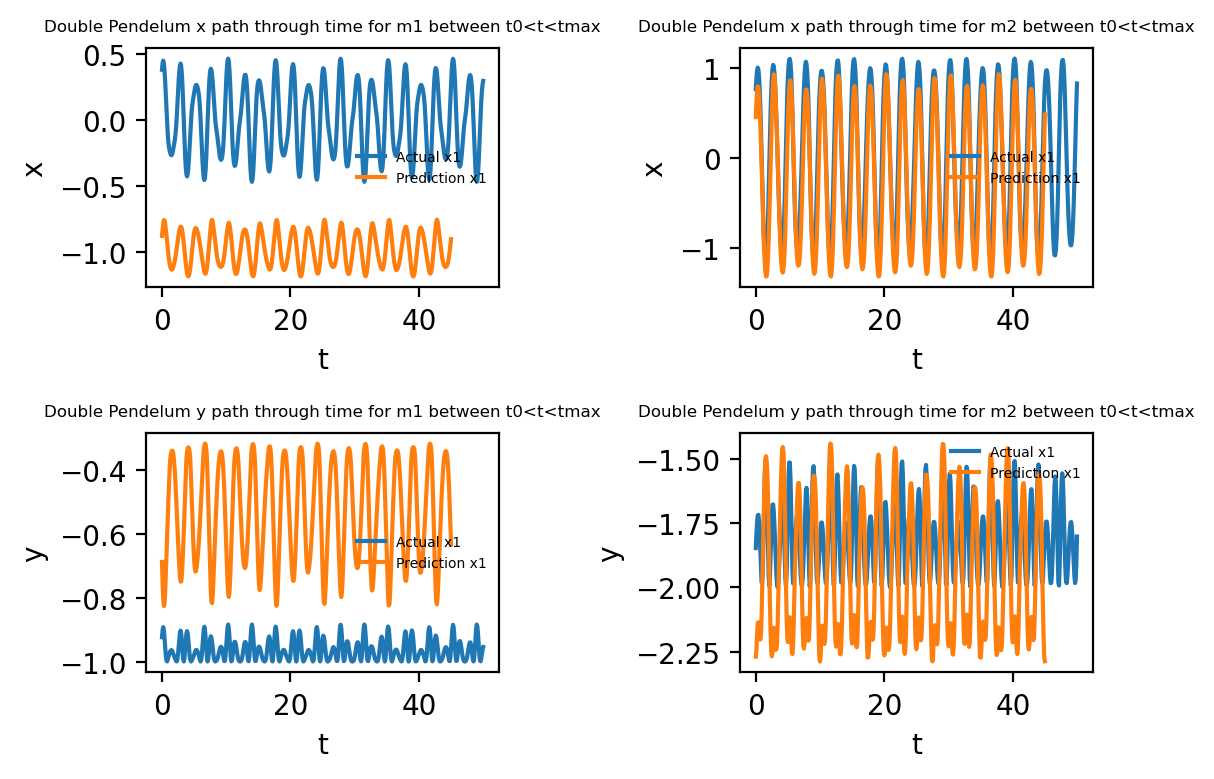

In [23]:
fig,ax=plt.subplots(nrows=2, ncols=2, )

#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test1[:,0])],test1[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})

#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test2[:,0])],test2[:,0],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})

#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test1[:,1])],test1[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})

#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test2[:,1])],test2[:,1],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})



fig.tight_layout()

#### Part 3:

Set z0 back to original and obtain neccesary values again:

In [24]:
z0=[np.pi/4,0,np.pi/4,0]

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)

(4, 501)


Create 5 new identical RNNs, each for one of the extrapolation times:

In [27]:
model1P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model1P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model1P5.add(keras.layers.Flatten())
model1P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model1P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model1P5.add(keras.layers.Dense(2, activation='linear')) 
model1P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model2P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model2P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model2P5.add(keras.layers.Flatten())
model2P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model2P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model2P5.add(keras.layers.Dense(2, activation='linear')) 
model2P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model3P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model3P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model3P5.add(keras.layers.Flatten())
model3P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model3P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model3P5.add(keras.layers.Dense(2, activation='linear')) 
model3P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model4P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model4P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model4P5.add(keras.layers.Flatten())
model4P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model4P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model4P5.add(keras.layers.Dense(2, activation='linear')) 
model4P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])


model5P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model5P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model5P5.add(keras.layers.Flatten())
model5P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model5P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model5P5.add(keras.layers.Dense(2, activation='linear')) 
model5P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])

Obtain inputs and targets for test and training data... for each extrapolation time using a for loop:

In [28]:
#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]

inp_tst1ARRAY =[]
trgt_tst1ARRAY=[]
inp_tst2ARRAY =[]
trgt_tst2ARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,20):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    
    test_inp1, test_lbl1 = create_dataset(test_data1,i, windowsize)
    test_inp2, test_lbl2 = create_dataset(test_data2,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    
    in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1])
    targ_test1 = test_lbl1.reshape(test_lbl1.shape[0], test_lbl1.shape[1])
    in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1])
    targ_test2 = test_lbl2.reshape(test_lbl2.shape[0], test_lbl2.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    
    inp_tst1ARRAY.append(in_test1)
    trgt_tst1ARRAY.append(targ_test1)    
    inp_tst2ARRAY.append(in_test2)
    trgt_tst2ARRAY.append(targ_test2) 

Train and test for each extrapolation time using `.fit` and obtain accuracy using `.evaluate`:

12/12 [==============================] - 0s 4ms/step - loss: 0.2924 - accuracy: 0.8410


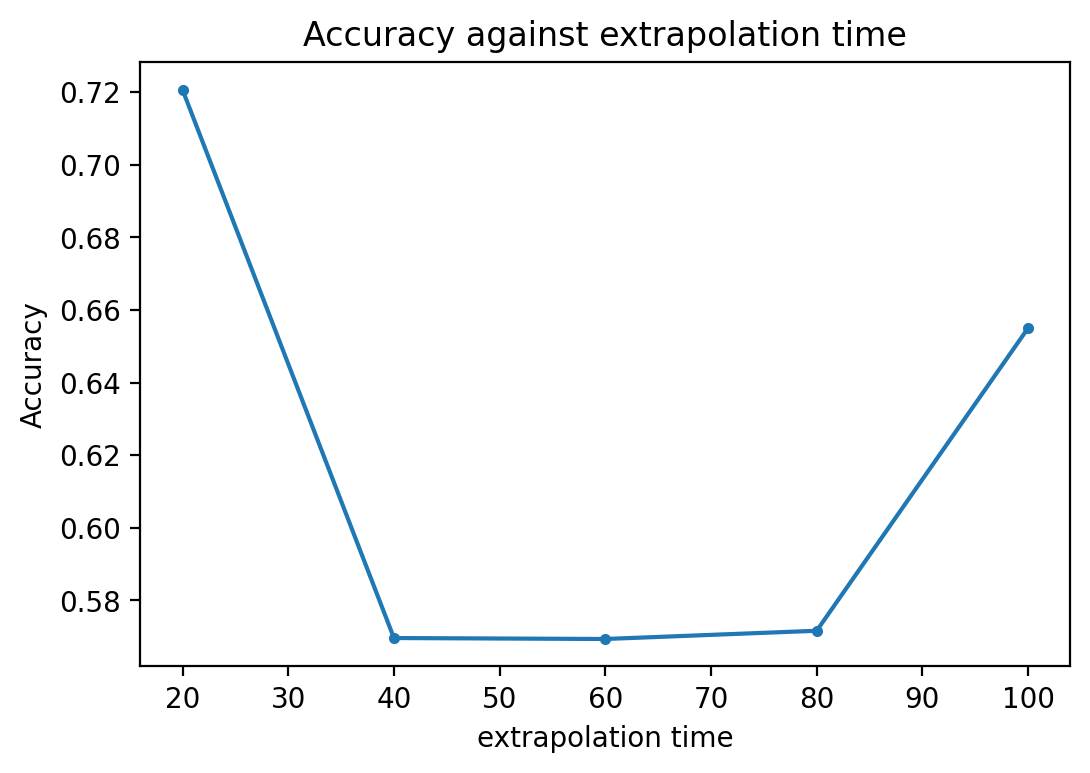

In [34]:
history1 = model1P5.fit(inp_trnARRAY[0], trgt_trnARRAY[0], epochs=30 , verbose=0)
test1_loss1, test1_acc1 = model1P5.evaluate(inp_tst1ARRAY[0], trgt_tst1ARRAY[0] , verbose=1)
test2_loss1, test2_acc1 = model1P5.evaluate(inp_tst2ARRAY[0], trgt_tst2ARRAY[0] , verbose=1)


history2 = model2P5.fit(inp_trnARRAY[1], trgt_trnARRAY[1], epochs=30, verbose=0)
test1_loss2, test1_acc2 = model1P5.evaluate(inp_tst1ARRAY[1], trgt_tst1ARRAY[1] , verbose=1)
test2_loss2, test2_acc2 = model1P5.evaluate(inp_tst2ARRAY[1], trgt_tst2ARRAY[1] , verbose=1)

history3 = model3P5.fit(inp_trnARRAY[2], trgt_trnARRAY[2], epochs=30, verbose=0)
test1_loss3, test1_acc3 = model1P5.evaluate(inp_tst1ARRAY[2], trgt_tst1ARRAY[2] , verbose=1)
test2_loss3, test2_acc3 = model1P5.evaluate(inp_tst2ARRAY[2], trgt_tst2ARRAY[2] , verbose=1)

history4 = model4P5.fit(inp_trnARRAY[3], trgt_trnARRAY[3], epochs=30, verbose=0)
test1_loss4, test1_acc4 = model1P5.evaluate(inp_tst1ARRAY[3], trgt_tst1ARRAY[3] , verbose=1)
test2_loss4, test2_acc4 = model1P5.evaluate(inp_tst2ARRAY[3], trgt_tst2ARRAY[3] , verbose=1)

history5 = model4P5.fit(inp_trnARRAY[4], trgt_trnARRAY[4], epochs=30, verbose=0)
test1_loss5, test1_acc5 = model1P5.evaluate(inp_tst1ARRAY[4], trgt_tst1ARRAY[4] , verbose=1)
test2_loss5, test2_acc5 = model1P5.evaluate(inp_tst2ARRAY[4], trgt_tst2ARRAY[4] , verbose=1)


test1_accARRAY= np.array([test1_acc1, test1_acc2, test1_acc3, test1_acc4, test1_acc5])
test2_accARRAY= np.array([test2_acc1, test2_acc2, test2_acc3, test2_acc4, test2_acc5])

test_accARRAY = (test1_accARRAY +test2_accARRAY)/2

plt.figure()
plt.plot(np.arange(20,101,20), test_accARRAY, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Accuracy")
plt.title("Accuracy against extrapolation time")
plt.show()

#### Part 4

Change initial condition:

In [35]:
#Starting angles
z0=[np.pi/2,0,np.pi/2,0]

Obtain new essential variables:

(4, 501)


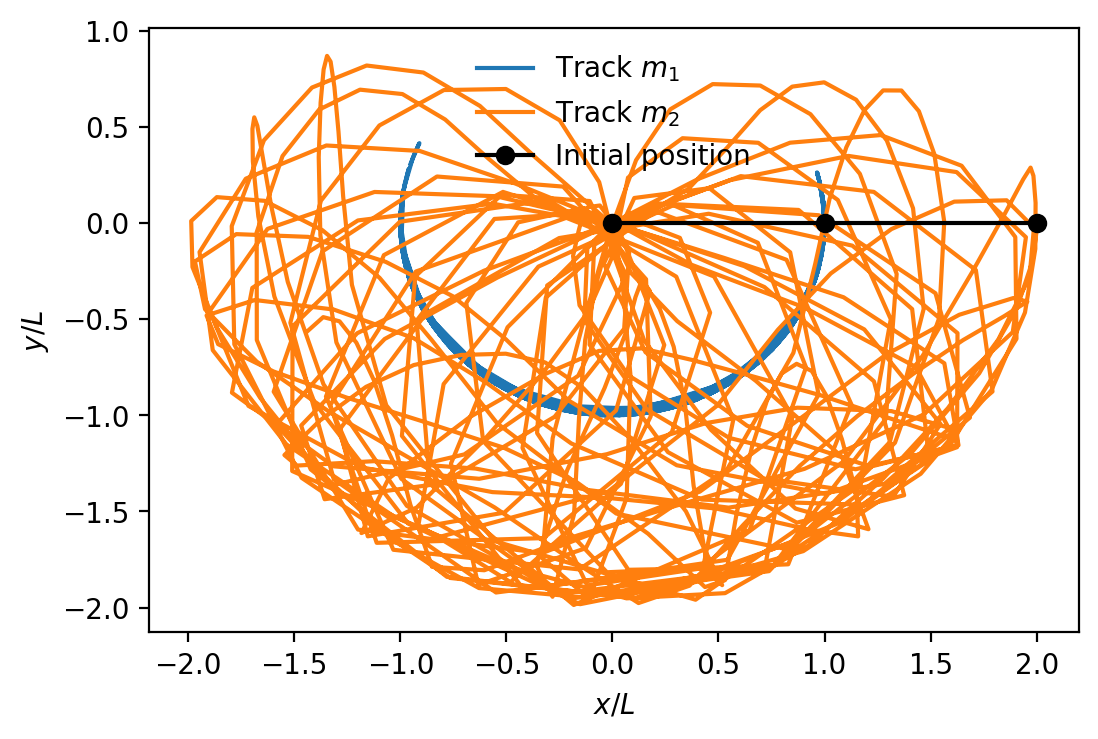

In [36]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration
#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt) 



# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)




fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

Repeat steps 1-3 all together:

###### PART 1:

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 28.65it/s]


The final cost for training data is 0.0007051159045659006
(451, 2)
(451, 2)
(451, 2)
(451, 2)


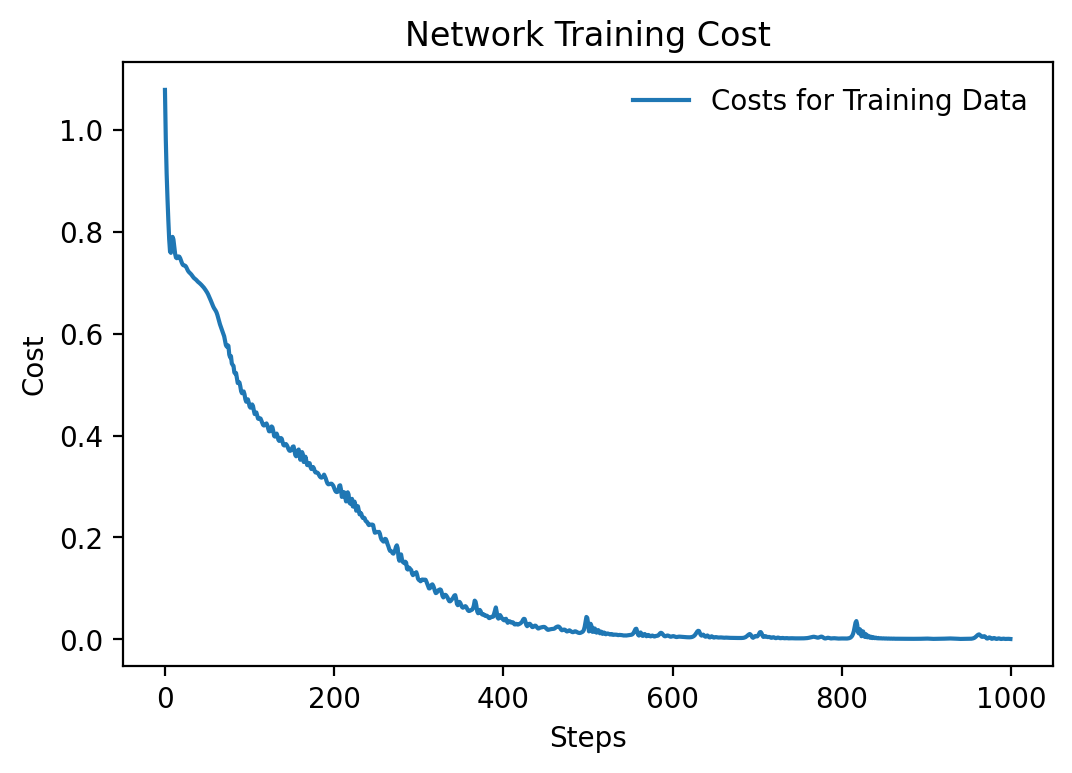

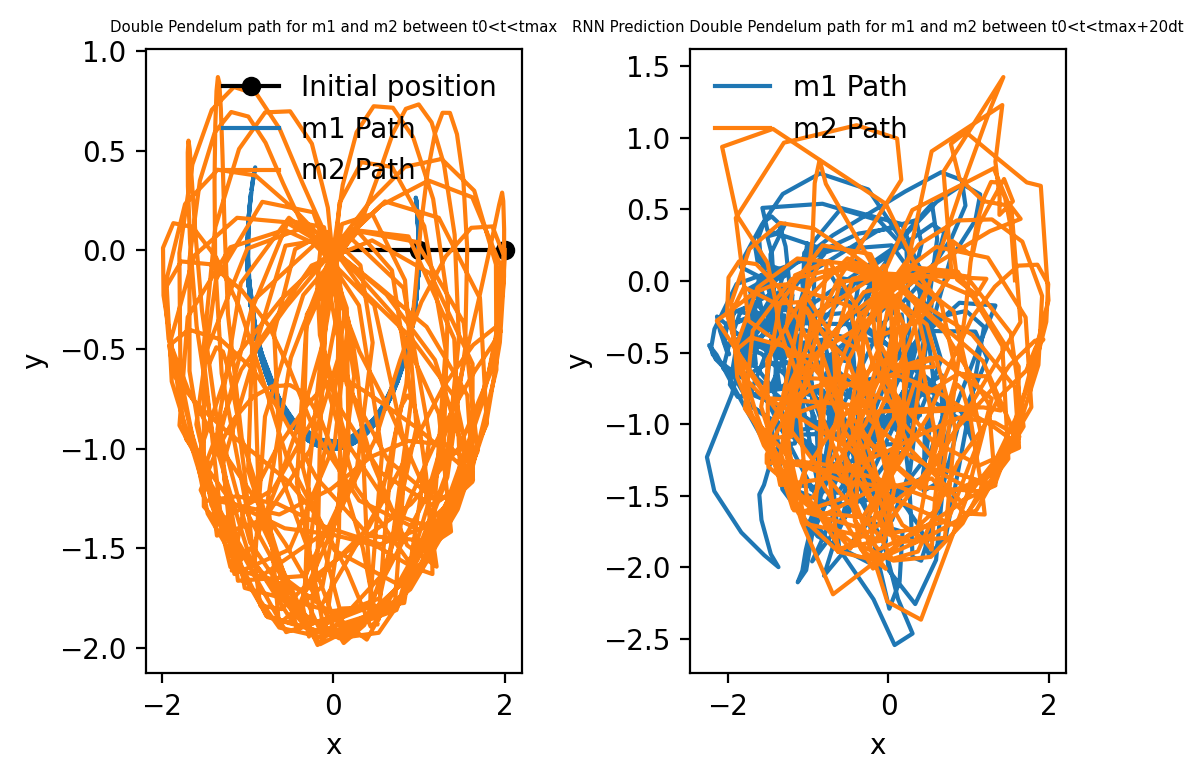

In [37]:
#REDEFINE RECURENCE NUERAL NETWORK (RNN):

#def RNN_P5(dimensions):
modelP5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 'demensions'
modelP5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 

#from sequential to flat NN:
modelP5.add(keras.layers.Flatten())

modelP5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
modelP5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer

#output layer with 4 nueron for each x1, x2, y1 or y2:
modelP5.add(keras.layers.Dense(2, activation='linear')) 

modelP5.compile(loss='mean_squared_error',optimizer='adam')
    
#return modelP5

windowsize=30 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict... this is the 20*dt part of the 'future' definition


#the following function was adapted from [2] 
def create_dataset(dataset,offset, windowsize):
    '''INPUTS:
    dataset: the 4-row array of x1,y1,x2 and y2 for either training or test
    offset: how many samples into the future to predict
    OUTPUTS:
    input_data: tuple of dataset for input into RNN
    label_data: tuple of dataset for target of RNN
    '''
    
    input_data, label_data = [], [] 
    #looping over the dataset
    for i in range(windowsize, len(dataset[0]) - offset):
        a = dataset[:,(i-windowsize):i] #
        
        input_data.append(a)
        label_data.append(dataset[:,i+offset])  
       
        
    input_data, label_data = np.array(input_data), np.array(label_data)
    return  input_data, label_data


#OBTAINING TEST AND TRAINING DATA:

#we get train the RNN over a limited range of the y data and x data 
#and test it over the full range:

y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)




#train:
steps=1000  #Number of training steps

costs=np.zeros(steps) #empty array for cost along each step

for i in tqdm(range(steps)):
    #reshape input and label training data so that it can be inputted into the RNN above:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1]) #reshape to have the dimensions (batchsize, time samples)
    
    costs[i]=modelP5.train_on_batch(in_train ,targ_train) #Train the network and append to 'costs' empty array


#plot train cost:
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs for Training Data")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

print("The final cost for training data is",costs[-1])


#test:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1) #gives output from RNN
print(test1.shape)
print(test_lbl1.shape)


fig,ax=plt.subplots(nrows=1, ncols=2, )

#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
#ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()


fig.tight_layout()

(4, 501)
(451, 2)
(451, 2)
(4, 501)
(451, 2)
(451, 2)


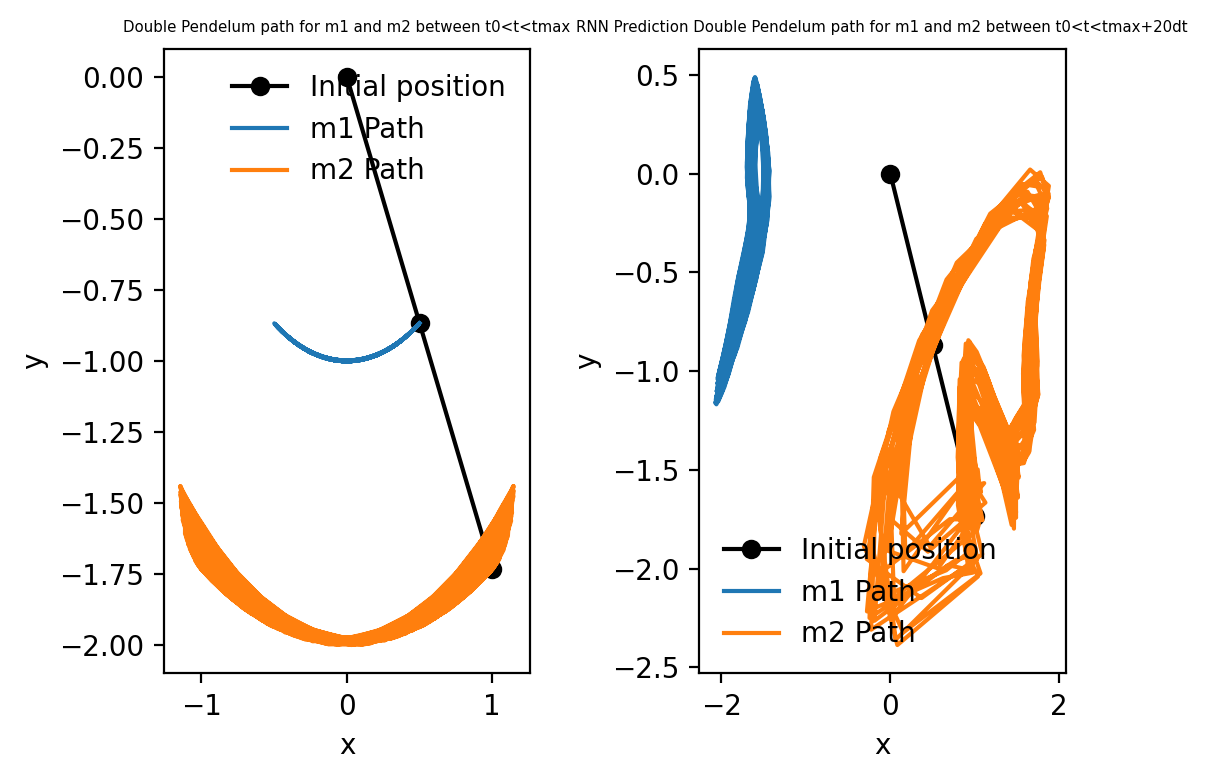

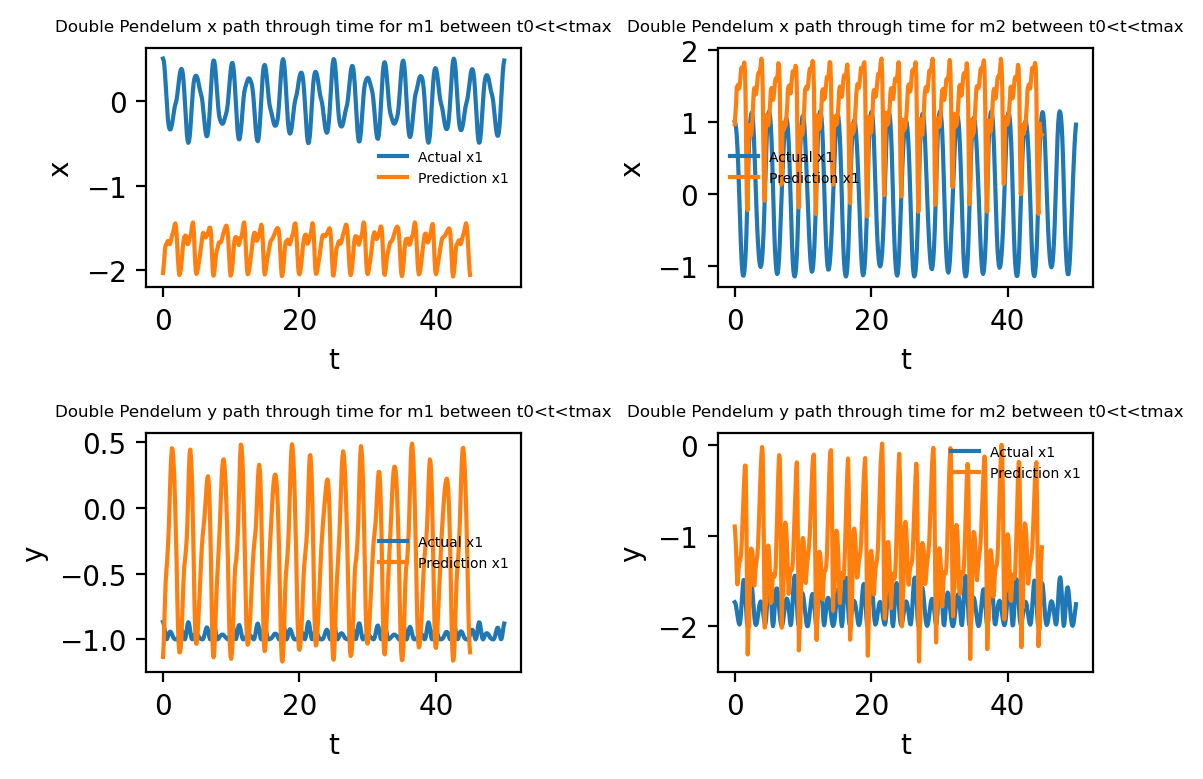

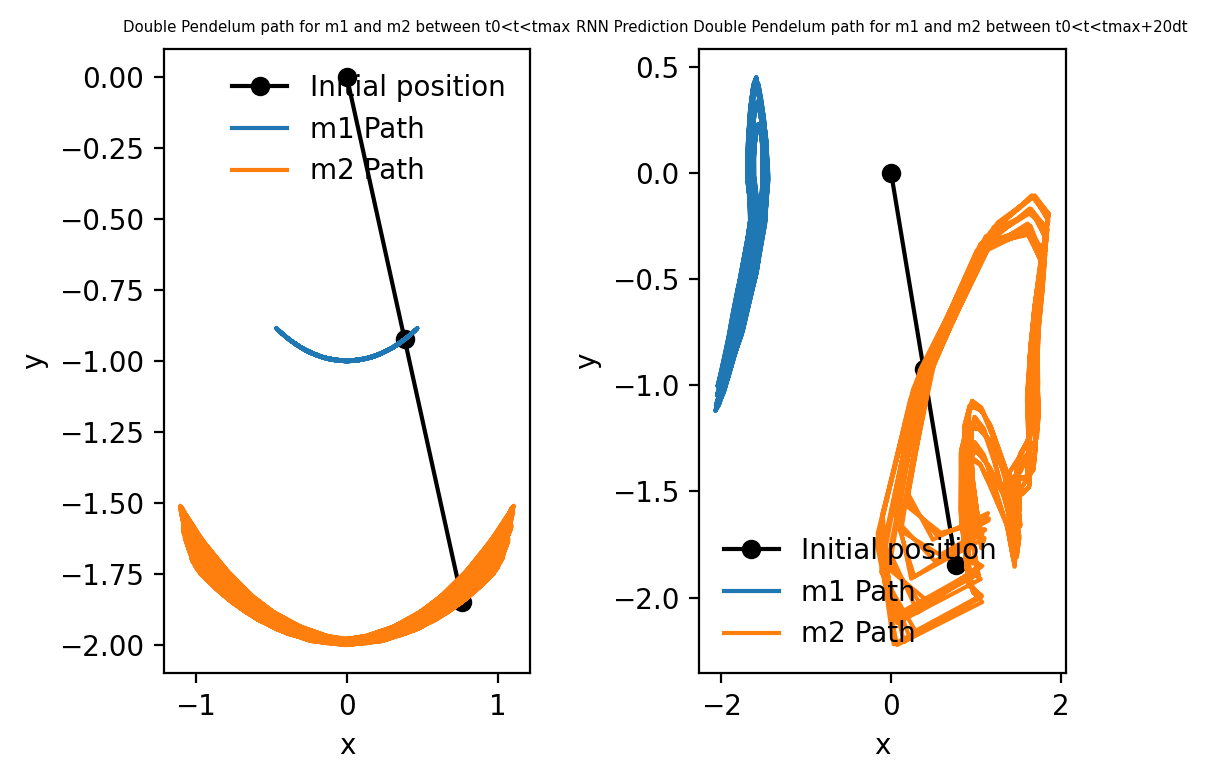

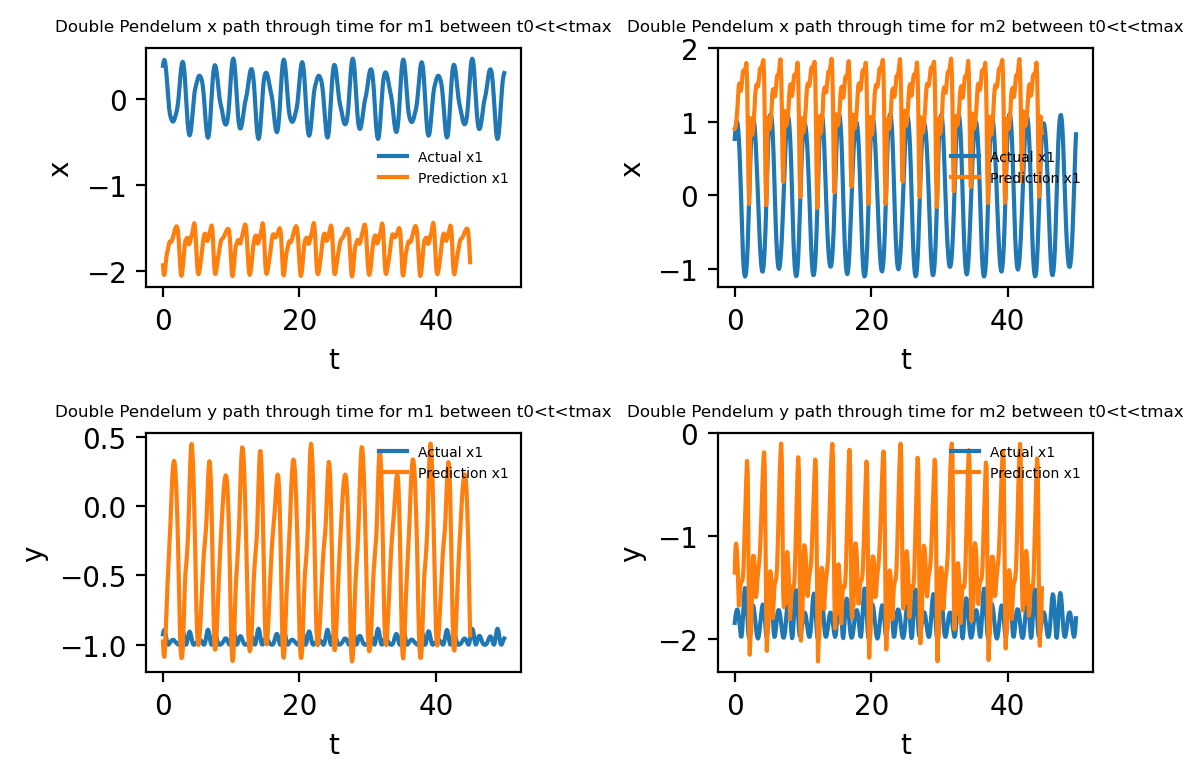

In [40]:
#### Part 2: 
z0=[np.pi/6,0,np.pi/6,0]

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 




#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)



#tEST W NEW test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1)


fig,ax=plt.subplots(nrows=1, ncols=2, )
#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()
fig.tight_layout()




fig,ax=plt.subplots(nrows=2, ncols=2, )
#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test1[:,0])],test1[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})
#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test2[:,0])],test2[:,0],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})
#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test1[:,1])],test1[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})
#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test2[:,1])],test2[:,1],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})
fig.tight_layout()



z0=[np.pi/8,np.pi/4,np.pi/8,np.pi/4]
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data
y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range
x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data
x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)



#tEST W NEW test data:
#we first have to reshape the test input data for the same reasons we did for the training input data
in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test2=modelP5.predict_on_batch(in_test2) #gives output from RNN
print(test2.shape)
print(test_lbl2.shape)
in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1]) #reshape to have the dimensions (batchsize, time samples, features)
test1=modelP5.predict_on_batch(in_test1)


fig,ax=plt.subplots(nrows=1, ncols=2, )
#rhs method plot:
ax[0].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[0].plot(x1,y1,label="m1 Path")
ax[0].plot(x2,y2,label="m2 Path")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Double Pendelum path for m1 and m2 between t0<t<tmax", size=5.4)
ax[0].legend()
#RNN method plot:
ax[1].plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
ax[1].plot(test1[:,0], test1[:,1],label="m1 Path")
ax[1].plot(test2[:,0], test2[:,1],label="m2 Path")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("RNN Prediction Double Pendelum path for m1 and m2 between t0<t<tmax+20dt", size=5.4)
ax[1].legend()
fig.tight_layout()



fig,ax=plt.subplots(nrows=2, ncols=2, )
#m1_x:
ax[0,0].plot(t,x1,label="Actual x1")
ax[0,0].plot(t[:len(test1[:,0])],test1[:,0],label="Prediction x1")
ax[0,0].set_xlabel("t")
ax[0,0].set_ylabel("x")
ax[0,0].set_title("Double Pendelum x path through time for m1 between t0<t<tmax", size=6)
ax[0,0].legend(prop={'size':5})
#m2_x:
ax[0,1].plot(t,x2,label="Actual x1")
ax[0,1].plot(t[:len(test2[:,0])],test2[:,0],label="Prediction x1")
ax[0,1].set_xlabel("t")
ax[0,1].set_ylabel("x")
ax[0,1].set_title("Double Pendelum x path through time for m2 between t0<t<tmax", size=6)
ax[0,1].legend(prop={'size':5})
#m1_y:
ax[1,0].plot(t,y1,label="Actual x1")
ax[1,0].plot(t[:len(test1[:,1])],test1[:,1],label="Prediction x1")
ax[1,0].set_xlabel("t")
ax[1,0].set_ylabel("y")
ax[1,0].set_title("Double Pendelum y path through time for m1 between t0<t<tmax", size=6)
ax[1,0].legend(prop={'size':5})
#m2_y:
ax[1,1].plot(t,y2,label="Actual x1")
ax[1,1].plot(t[:len(test2[:,1])],test2[:,1],label="Prediction x1")
ax[1,1].set_xlabel("t")
ax[1,1].set_ylabel("y")
ax[1,1].set_title("Double Pendelum y path through time for m2 between t0<t<tmax", size=6)
ax[1,1].legend(prop={'size':5})
fig.tight_layout()

(4, 501)
12/12 [==============================] - 0s 5ms/step - loss: 0.3285 - accuracy: 0.7278


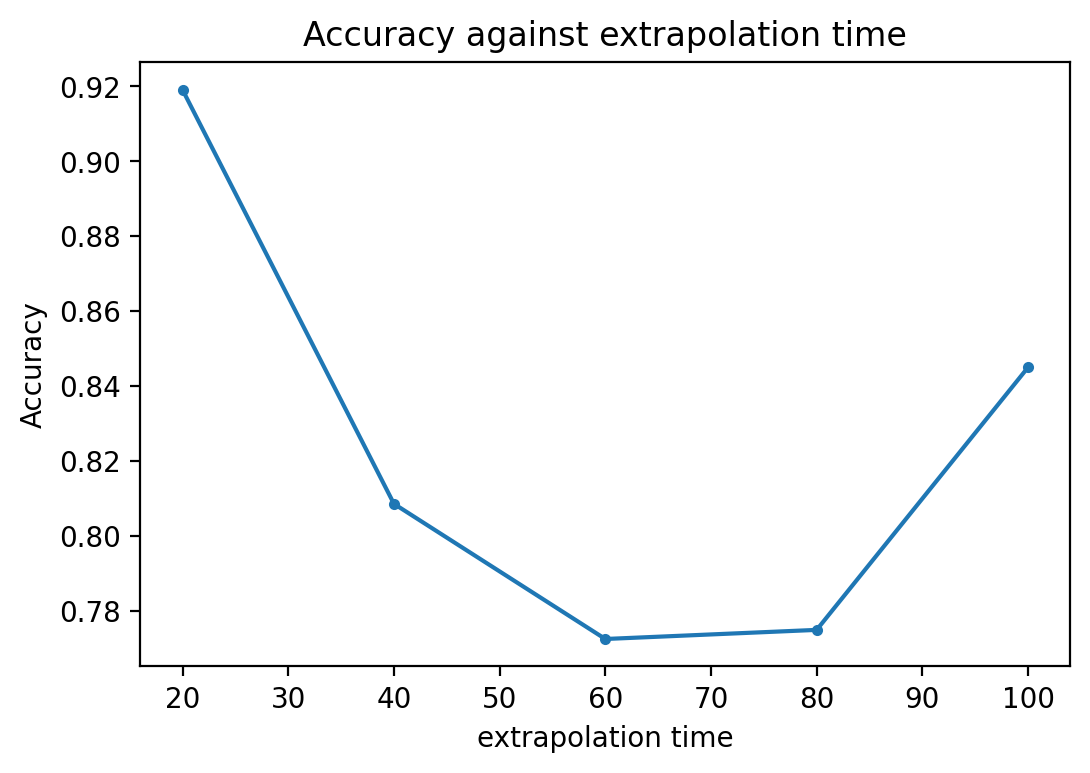

In [44]:
#### Part 3:
z0=[np.pi/4,0,np.pi/4,0]

# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))
 
# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)


#Obtaining new test datra
y1_train=y1[0:int(0.7*len(y1))] #y1 training data will be 70% of the full data
y2_train=y2[0:int(0.7*len(y2))] #y2 training data will be 70% of the full data

y1_test=y1 #y1 test data will be over the full range
y2_test=y2 #y2 test data will be over the full range

x1_train=x1[0:int(0.7*len(x1))] #y1 training data will be 70% of the full data
x2_train=x2[0:int(0.7*len(x2))] #y2 training data will be 70% of the full data

x1_test=x1 #y1 test data will be over the full range
x2_test=x2 #y2 test data will be over 


#M1 AND M2 TEST DATA:
test_data1=np.column_stack((x1_test, y1_test)).T
test_data2 = np.column_stack((x2_test, y2_test)).T
#M2 TRAIN DATA:
train_data = np.column_stack((x2_train, y2_train)).T


#trainng and test dataset(input and labels for NN):
train_inp, train_lbl = create_dataset(train_data,offset, windowsize)

test_inp1, test_lbl1 = create_dataset(test_data1,offset, windowsize)
test_inp2, test_lbl2 = create_dataset(test_data2,offset, windowsize)




model1P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model1P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model1P5.add(keras.layers.Flatten())
model1P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model1P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model1P5.add(keras.layers.Dense(2, activation='linear')) 
model1P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
model2P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model2P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model2P5.add(keras.layers.Flatten())
model2P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model2P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model2P5.add(keras.layers.Dense(2, activation='linear')) 
model2P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
model3P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model3P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model3P5.add(keras.layers.Flatten())
model3P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model3P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model3P5.add(keras.layers.Dense(2, activation='linear')) 
model3P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
model4P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model4P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model4P5.add(keras.layers.Flatten())
model4P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model4P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model4P5.add(keras.layers.Dense(2, activation='linear')) 
model4P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])
model5P5=keras.models.Sequential()
#LSTM layer with 50 neurons. Input shape is 4 for each x1,x2,y1 and y2:
model5P5.add(keras.layers.LSTM(50,input_shape=(None, 2))) 
#from sequential to flat NN:
model5P5.add(keras.layers.Flatten())
model5P5.add(keras.layers.Dense(512, activation='relu')) #add hidden ralyer
model5P5.add(keras.layers.Dense(128, activation='relu')) #add hidden ralyer
#output layer with 4 nueron for each x1, x2, y1 or y2:
model5P5.add(keras.layers.Dense(2, activation='linear')) 
model5P5.compile(loss='mean_squared_error',optimizer='adam', metrics=['accuracy'])



#inintialise empty arrays for input and target, training and testing data:
inp_trnARRAY =[] #input training empty array
trgt_trnARRAY=[]
inp_tst1ARRAY =[]
trgt_tst1ARRAY=[]
inp_tst2ARRAY =[]
trgt_tst2ARRAY=[]

#loop over desired extrapolation times:
for i in np.arange(20,101,20):
    #trainng and test dataset(input and labels for NN):
    train_inp, train_lbl = create_dataset(train_data,i, windowsize)
    
    test_inp1, test_lbl1 = create_dataset(test_data1,i, windowsize)
    test_inp2, test_lbl2 = create_dataset(test_data2,i, windowsize)

    #reshape:
    in_train = train_inp.reshape(train_inp.shape[0], windowsize, train_inp.shape[1])
    targ_train = train_lbl.reshape(train_lbl.shape[0], train_inp.shape[1])
    
    in_test1 = test_inp1.reshape(test_inp1.shape[0],windowsize, test_inp1.shape[1])
    targ_test1 = test_lbl1.reshape(test_lbl1.shape[0], test_lbl1.shape[1])
    in_test2 = test_inp2.reshape(test_inp2.shape[0],windowsize, test_inp2.shape[1])
    targ_test2 = test_lbl2.reshape(test_lbl2.shape[0], test_lbl2.shape[1])
    
    inp_trnARRAY.append(in_train)
    trgt_trnARRAY.append(targ_train)
    
    inp_tst1ARRAY.append(in_test1)
    trgt_tst1ARRAY.append(targ_test1)    
    inp_tst2ARRAY.append(in_test2)
    trgt_tst2ARRAY.append(targ_test2) 



history1 = model1P5.fit(inp_trnARRAY[0], trgt_trnARRAY[0], epochs=30 , verbose=0)
test1_loss1, test1_acc1 = model1P5.evaluate(inp_tst1ARRAY[0], trgt_tst1ARRAY[0] , verbose=1)
test2_loss1, test2_acc1 = model1P5.evaluate(inp_tst2ARRAY[0], trgt_tst2ARRAY[0] , verbose=1)
history2 = model2P5.fit(inp_trnARRAY[1], trgt_trnARRAY[1], epochs=30, verbose=0)
test1_loss2, test1_acc2 = model1P5.evaluate(inp_tst1ARRAY[1], trgt_tst1ARRAY[1] , verbose=1)
test2_loss2, test2_acc2 = model1P5.evaluate(inp_tst2ARRAY[1], trgt_tst2ARRAY[1] , verbose=1)
history3 = model3P5.fit(inp_trnARRAY[2], trgt_trnARRAY[2], epochs=30, verbose=0)
test1_loss3, test1_acc3 = model1P5.evaluate(inp_tst1ARRAY[2], trgt_tst1ARRAY[2] , verbose=1)
test2_loss3, test2_acc3 = model1P5.evaluate(inp_tst2ARRAY[2], trgt_tst2ARRAY[2] , verbose=1)
history4 = model4P5.fit(inp_trnARRAY[3], trgt_trnARRAY[3], epochs=30, verbose=0)
test1_loss4, test1_acc4 = model1P5.evaluate(inp_tst1ARRAY[3], trgt_tst1ARRAY[3] , verbose=1)
test2_loss4, test2_acc4 = model1P5.evaluate(inp_tst2ARRAY[3], trgt_tst2ARRAY[3] , verbose=1)
history5 = model4P5.fit(inp_trnARRAY[4], trgt_trnARRAY[4], epochs=30, verbose=0)
test1_loss5, test1_acc5 = model1P5.evaluate(inp_tst1ARRAY[4], trgt_tst1ARRAY[4] , verbose=1)
test2_loss5, test2_acc5 = model1P5.evaluate(inp_tst2ARRAY[4], trgt_tst2ARRAY[4] , verbose=1)


test1_accARRAY= np.array([test1_acc1, test1_acc2, test1_acc3, test1_acc4, test1_acc5])
test2_accARRAY= np.array([test2_acc1, test2_acc2, test2_acc3, test2_acc4, test2_acc5])

test_accARRAY = (test1_accARRAY +test2_accARRAY)/2

plt.figure()
plt.plot(np.arange(20,101,20), test_accARRAY, '.-')
plt.xlabel("extrapolation time")
plt.ylabel("Accuracy")
plt.title("Accuracy against extrapolation time")
plt.show()

### Part 5 Comments:

Very innacurate which is expected since the RNN hasnt been trained on m1 data.

# Bibliography:

[1] Nichol. R 2021. "Week6_Predictoin". [Online] UCL Moodle resource. Available from https://moodle.ucl.ac.uk/course/view.php?id=6793 [accessed 20th November 2021]

[2] H.K. Singh 2021. " Predicting The Chaotic Trajectory Double Pendulum Using LSTM". [Online] UCL Moodle resource. Available from https://pianalytix.com/predicting-the-chaotic-trajectory-double-pendulum-using-lstm/ [acessed 22nd November 2021]